# CLASE 2.5: Máquinas de soporte vectorial.
---

## Introducción.
Como ya hemos tenido la oportunidad de revisar en algunos casos generales, en muchas situaciones estaremos interesados en construir modelos de clasificación. Vale decir, querremos que un modelo prediga uno de varios resultados (discretos) posibles. Un ejemplo típico de un problema de este tipo lo podemos ver a diario a la hora de abrir nuestro cliente favorito de correo electrónico, ya que éste es capaz de clasificar sin mayor problema los correos importantes de aquellos que posiblemente no sean de interés (categorizándolos como *spam*). Otros ejemplos más sofisticados incluyen clasificadores de imágenes que permiten diferenciar elementos de interés –por ejemplo, personas– en un set de imágenes dado. Sea cual sea el caso, es normal que exista un pequeño número de resultados posibles para un fenómeno de interés y, más importante aún, que no existan estructuras adicionales para tales resultados. 

En esta sección, consideraremos, a nivel teórico, problemas de clasificación binaria para los cuales estamos interesados en obtener predictores del tipo

$$f:\mathbb{R}^{n}\longrightarrow \left\{ -1,+1\right\}$$
<p style="text-align: right;">$(5.1)$</p>

El problema, en términos generales, siempre podrá expresarse de la forma $\mathcal{D} =\left\{ \left( \mathbf{X} ,\mathbf{y} \right)  :\mathbf{X} =\left\{ x_{ij}\right\}  \in \mathbb{R}^{m\times n} \wedge \mathbf{y} \in \mathbb{R}^{m} \right\}$, donde $\mathcal{D}$ es un conjunto de entrenamiento, $\mathbf{X}$ es la matriz de variables independientes que caracteriza a los datos de entrada del problema (con $m$ instancias y $n$ atributos) e $\mathbf{y}$ es un vector que aglutina los valores que deseamos estimar, y que pueden ser iguales a $-1$ o $+1$, según sea el caso. Naturalmente, al valor $y_{i}=+1;\forall i=1,...,m$ lo llamaremos **clase positiva**, y al valor $y_{i}=-1;\forall i=1,...,m$ lo llamaremos **clase negativa**. Debemos tener cuidado en no inferir *cualidades* positivas respecto de la clase positiva, ya que la forma de llamar a ambas clases es simplemente una convención. Por ejemplo, en un caso de negocio asociado a minería subterránea, podríamos estar interesados en estimar la probabilidad de que ocurran estallidos de roca en un nivel de producción, siendo la ocurrencia de tales estallidos en el pasado etiquetada con el valor $y_{i}=+1$. Esto, por supuesto, no es algo *positivo* a nivel de negocio (no queremos, por ningún motivo, que ocurran estallidos de roca). Pero en un problema de clasificación, es evidente que $y_{i}=+1$ será la *clase positiva*.

A diferencia de la sección 2.3, donde nos esforzamos en mostrar distintas implementaciones de modelos lineales generalizados para resolver un problema de clasificación binario, en esta oportunidad nos limitaremos a un enfoque más específico, y que se conoce universalmente como **máquina de soporte vectorial** o **máquina de vectores de soporte** (del inglés **support vector machine**, y que abreviaremos típicamente como **SVM**). El modelo SVM es capaz de resolver cualquier problema binario expresado como $\mathcal{D}$, incluso si las fronteras que separan las clases positiva y negativa en $\mathcal{D}$ no son lineales (o dicho de otra forma, problemas no linealmente separables). Para este último caso, haremos uso de un recurso matemático que ya vimos en el curso de [Análisis de Datos](https://github.com/rquezadac/udd_data_analytics_lectures), y que corresponde a las funciones kernel ([clase 4.1](https://github.com/rquezadac/udd_data_analytics_lectures/blob/main/Seccion%204%20-%20Introducci%C3%B3n%20al%20an%C3%A1lisis%20num%C3%A9rico%20y%20simb%C3%B3lico%20con%20Scipy%20y%20Sympy/clase_4_1.ipynb)).

Las SVMs nos proveen de resultados poderosos en muchísimas aplicaciones académicas e industriales relativas a problemas de clasificación, apoyándose de teoremas bien fundamentados. Se trata además de un modelo que aprovecha algunas cuestiones geométricas inherentes a los problemas de clasificación y que permiten ilustrar su implementación (y calidad) de manera relativamente sencilla. Por lo tanto, se trata de un enfoque esencial en el modelamiento predictivo y que debemos siempre tener disponible en nuestra caja de herramientas. Además, es un excelente caso de ejemplo en lo que respecta a la formulación de un problema de optimización desde la perspectiva de la dualidad.

Consideremos pues un problema de clasificación binaria representado por el conjunto de entrenamiento $\mathcal{D}$. Cada par $\left( \mathbf{x}_{i} ,y_{i}\right)$, donde $\mathbf{x}_{i}$ es una matriz fila que simplemente representa la instancia $i$-ésima asociada a la matriz de atributos $\mathbf{X}$, hace corresponder a un ejemplo observado $\mathbf{x}_{i}$ una etiqueta o clase $y_{i}$ (siendo $1\leq i\leq m$). Si $x_{i}\in \mathbb{R}^{2}$, el problema puede ilustrarse geométricamente en el plano $\mathbb{R}^{2}$ *pintando* cada punto $x_{i}$ de un color si $y_{i}=1$ (la clase positiva), y de otro color si $y_{i}=0$ (la clase negativa). Notemos que, en este ejemplo práctico, hemos asignado el valor $0$ a la clase negativa, fundamentalmente porque, en **<font color='mediumorchid'>Scikit-Learn</font>**, las clases en un problema de clasificación suelen empezar a numerarse precisamente desde el cero. Ejemplifiquemos ésto haciendo uso de algo de código, tomando como base la función `make_blobs()` del módulo `sklearn.datasets`. Para ello, haremos uso de las importaciones usuales:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
from sklearn.datasets import make_blobs

In [3]:
plt.rcParams["figure.dpi"] = 110
sns.set()
plt.style.use("bmh")

In [4]:
%matplotlib widget

La función `make_blobs()` nos permite construir un conjunto de datos tal que los puntos que lo componen se agrupen en torno a un determinado centroide en el espacio de atributos, de manera tal que se generen nubes de puntos bien diferenciadas, similares a clusters en dicho espacio. Suele utilizarse mayormente para el testeo de algoritmos de agrupamiento, pero será perfecta para ejemplificar nuestro caso. El parámetro `n_samples` permite especificar el total de puntos que compondrán el dataset, `centers` el total de clusters, `n_features` el total de variables independientes del mismo y `center_box` las coordenadas relativas al centro de simetría de los clusters en un espacio de 10$\times$10. Por lo tanto, construir un dataset que represente un problema de clasificación binaria a partir de esta función resulta bastante sencillo:

In [5]:
X, y = make_blobs(n_samples=1000, centers=2, n_features=2, center_box=(0, 15), random_state=42)

La función `make_blobs()` retorna una tupla de arreglos que hemos denominado como `X, y`, donde `X` representa a las variables independientes (atributos) del dataset e `y` representa un indicador que asigna cada punto a un clúster determinado. En nuestro ejemplo, debido a que `X` es una matriz en $\mathbb{R}^{1000\times 2}$, se tienen dos clusters y, por tanto, `y` únicamente toma los valores `0` y `1`. Tenemos pues un dataset perfecto para ser utilizado como base para un modelo de clasificación binaria. Si graficamos este dataset, observamos la siguiente disposición de los puntos:

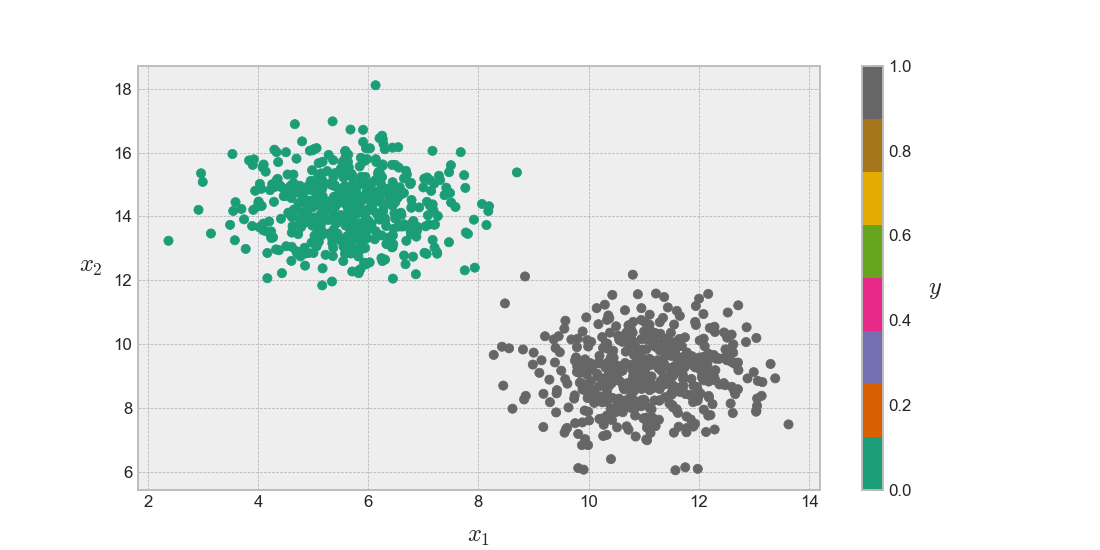

In [6]:
fig, ax = plt.subplots(figsize=(10, 5))
p = ax.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap="Dark2")
ax.set_xlabel(r"$x_{1}$", fontsize=16, labelpad=10)
ax.set_ylabel(r"$x_{2}$", fontsize=16, labelpad=15, rotation=0)
cb = fig.colorbar(p)
cb.set_label(r"$y$", fontsize=16, labelpad=15, rotation=0);

Tenemos pues que los puntos tales que `y = 0` han sido coloreados de verde, mientras que aquellos puntos tales que `y = 1` han sido coloreados de gris.

Sean pues, en notación matemática, $\mathbf{X}\in \mathbb{R}^{m\times 2}$ e $\mathbf{y}\in \mathbb{R}^{m}$, la matriz de variables independientes y el vector de valores objetivo, respectivamente (con $m=1000$, en este ejemplo). Cada instancia $\mathbf{x}_{i}\in \mathbb{R}^{2}$ ($1\leq i\leq m$) es un vector en el espacio bidimensional que podemos expresar como $(x_{i1},x_{i2})$ para cada instancia $i$, siendo $y_{i}$ su correspondiente clase o etiqueta. En este contexto, definimos la **frontera de separación** entre ambas clases como la curva que *mejor separa* los puntos $(x_{i1},x_{i2})$ tales que $y_{i}=-1$, de aquellos tales que $y_{i}=+1$ (ahora hemos vuelto a llamar a la clase negativa como $y_{i}=-1$, lo que suele ser un enfoque mucho más apropiado en la teoría subyacente a las SVMs). La *mejor separación* es un criterio que suena antojadizo, pero en realidad se basa a partir de cuestiones puramente geométricas. De este modo, una separación entre clases es óptima cuando las distancias (euclidianas, en este caso) entre la frontera de separación y los puntos más cercanos a la misma de cada clase son lo más grandes posibles.

Las SVMs abordan el enfoque geométrico anterior, planteando un problema de optimización donde el objetivo es determinar un **hiperplano de separación** en vez de una curva completamente arbitraria entre ambas clases. Naturalmente, en $\mathbb{R}^{2}$, tal hiperplano es una recta. Y, en consecuencia, las SVMs son un ejemplo de **modelo lineal generalizado**. Formalmente, podemos definir este hiperplano tomando prestadas algunas definiciones del álgebra lineal, debido a que, tomando como base el hecho de que si el conjunto de datos de interés *vive* en un espacio vectorial de dimensión $n$ (por lo general, euclidiano), es evidente que el hiperplano de separación es un subespacio vectorial de dimensión $n-1$. En la práctica esto puede resultar evidente, ya que, en el ejemplo anterior, el conjunto de datos está definido en un dominio de $\mathbb{R}^{2}$, y el *hiperplano* de separación es una recta que describe un subespacio en $\mathbb{R}$ (definido por una ecuación del tipo $y=ax+b$, donde $a$ y $b$ son los parámetros que deseamos determinar).

En este apartado formalizaremos el procedimiento para encontrar la mejor separación entre las clases que caracterizan a un problema de separación binaria. Esto bastará para formar una noción completamente robusta de la teoría subyacente a las SVMs puesto que, en casos multinomiales, siempre podremos descomponer tales problemas en sub-problemas binarios. Introduciremos el concepto de **margen** y consideraremos aquellos casos donde un hiperplano es insuficiente para separar adecuadamente las clases que caracterizan a un problema, lo que incurrirá en un **error de clasificación**. Presentaremos dos enfoques equivalentes para darle sustento matemático a las SVMs: Uno geométrico y otro basado en la función de costo. Revisaremos el problema de optimización subyacente a las SVMs y derivaremos el correspondiente problema dual usando el método de los **multiplicadores de Lagrange** (aunque será válido también un enfoque más general, como el uso de las condiciones de Karuhn-Kush-Tucket, KKT). La **SVM dual** nos permitirá plantear un tercer enfoque para formalizar su sustento matemático aprovechando una propiedad interesante de los conjuntos convexos. Finalmente, revisaremos cómo construir fronteras de separación más generales que un simple hiperplano haciendo uso de **funciones kernel**.

## El hiperplano de separación.
Consideremos un conjunto de datos de la forma $\mathcal{D} =\left\{ \left( \mathbf{X} ,\mathbf{y} \right)  :\mathbf{X} =\left\{ x_{ij}\right\}  \in \mathbb{R}^{m\times n} \wedge \mathbf{y} \in \mathbb{R}^{m} \right\}$, tal que $y_{i}=+1$ será llamada **clase positiva** e $y_{i}=-1$ será llamada **clase negativa**. Sean $i$ y $j$ los indexadores de filas y columnas, respectivamente, de la matriz de atributos $\mathbf{X}$, y llamemos $\mathbf{x}_{p}$ y $\mathbf{x}_{q}$ a dos instancias (filas) de $\mathbf{X}$. Recordemos, del álgebra lineal, que una forma de establecer qué tan *similares* son dos vectores –en este caso $\mathbf{x}_{p}$ y $\mathbf{x}_{q}$– es mediante el uso del producto interno $\left< \mathbf{x}_{p} ,\mathbf{x}_{q} \right>$. Sabemos también que, en un contexto geométrico, los productos internos permiten definir conceptos tales como el *ángulo* entre los vectores $\mathbf{x}_{p}$ y $\mathbf{x}_{q}$, y que el valor de $\left< \mathbf{x}_{p} ,\mathbf{x}_{q} \right>$ depende de la norma (inducida por ese mismo producto interno) de los vectores $\mathbf{x}_{p}$ y $\mathbf{x}_{q}$. Finalmente, sabemos también que el producto interno es un ingrediente esencial a la hora de definir conceptos tales como proyecciones u ortogonalidad.

La idea general de un modelo de clasificación, como sabemos, es particionar el espacio $\mathbb{R}^{n}$ donde *viven* nuestros datos de manera tal que instancias asociadas a una determinada clase (y no otra) queden *encapsulados* en una misma partición. Por supuesto, en un problema binario, tal espacio quedará dividido en dos particiones que se corresponderán, respectivamente, con las clases positiva y negativa asociadas a los puntos que representan a los datos. Consideraremos pues una partición conveniente, cuyo objetivo es separar, linealmente, al espacio $\mathbb{R}^{n}$ haciendo uso de un hiperplano. Sea $\mathbf{x}\in \mathbb{R}^{n}$ una instancia de $\mathbf{X}$, y consideremos la función

$$\begin{array}{l}f:\mathbb{R}^{n} \longrightarrow \mathbb{R} \\ \mathbf{x} \longmapsto f\left( \mathbf{x} \right)  :=\left< \mathbf{w} ,\mathbf{x} \right>  +b\end{array}$$
<p style="text-align: right;">$(5.2)$</p>

donde $\mathbf{w}\in \mathbb{R}^{n}$ y $b\in \mathbb{R}$ son parámetros. Tiene sentido entonces la siguiente definición.

**<font color='blue'>Definición 5.1 – Hiperplano de separación:</font>** Sea $\mathcal{D} =\left\{ \left( \mathbf{X} ,\mathbf{y} \right)  :\mathbf{X} =\left\{ x_{ij}\right\}  \in \mathbb{R}^{m\times n} \wedge \mathbf{y} \in \mathbb{R}^{m} \right\}$ un conjunto de entrenamiento tal que $\mathbf{y}$ únicamente puede tomar los valores $+1$ o $-1$, y sea $\mathbf{x}\in \mathbb{R}^{n}$ una instancia (fila) de $\mathbf{X}$. Se define el hiperplano que separa las clases $y_{i}=+1$ e $y_{i}=-1$, llamado **hiperplano de separación**, como el conjunto

$$\mathcal{H} =\left\{ \mathbf{x} \in \mathbb{R}^{n} :f\left( \mathbf{x} \right)  =0\right\}$$
<p style="text-align: right;">$(5.3)$</p>

donde $f$ es la función que hemos definido en la ecuación (5.2).

Podemos observar una ilustración del hiperplano de separación en la Fig. (5.1), donde hemos escrito explícitamente la ecuación de dicho hiperplano descomponiendo su ecuación $\left< \mathbf{w} ,\mathbf{x} \right>  +b=0$ en componentes, tomando $\mathbf{w}=(w_{1},w_{2})$ para este ejemplo en particular. En este contexto, $b$ es simplemente la coordenada $x_{2}$ del hiperplano cuando $x_{1}=0$, denominándose por tanto **parámetro de sesgo** del mismo.

<p style="text-align: center;"><img src="figures/fig_5_1.png" width="500"></p>
<p style="text-align: center;">Fig. (5.1): Ilustración del hiperplano de separación (en este caso, una recta) que separa las clases positiva y negativa de un problema de clasificación en $\mathbb{R}^{2}$</p>

En un caso más general, digamos de $n$ dimensiones, es evidente que $\mathbf{w}\in \mathbb{R}^{n}$ es un vector normal al hiperplano (5.2). Podemos demostrar aquello tomando dos instancias pertenecientes al hiperplano, digamos $\mathbf{x}_{p}$ y $\mathbf{x}_{q}$, y mostrando que el vector que une a ambos puntos es ortogonal a $\mathbf{w}$ considerando las propiedades del producto interno. En efecto,

$$\begin{array}{lll}f\left( \mathbf{x}_{p} \right)  -f\left( \mathbf{x}_{q} \right)  &=&\left< \mathbf{w} ,\mathbf{x}_{p} \right>  +b-\left( \left< \mathbf{w} ,\mathbf{x}_{q} \right>  +b\right)  \\ &=&\left< \mathbf{w} ,\mathbf{x}_{p} -\mathbf{x}_{q} \right>  \  \left( \mathrm{linealidad\  del\  producto\  interno} \right)  \end{array}$$
<p style="text-align: right;">$(5.4)$</p>

Dado que $\mathbf{x}_{p}$ y $\mathbf{x}_{q}$ se encuentran en el hiperplano, se tiene que $f(\mathbf{x}_{p})=f(\mathbf{x}_{q})=0$ y, por extensión, $\left< \mathbf{w} ,\mathbf{x}_{p} -\mathbf{x}_{q} \right>  =0$, lo que implica que, en efecto, el vector que separa a $\mathbf{x}_{p}$ y $\mathbf{x}_{q}$ es ortogonal a $\mathbf{w}$. De este modo, $\mathbf{w}$ es ortogonal a cualquier vector paralelo al hiperplano.

Cuando disponemos de instancias de prueba, queremos clasificar tales instancias como positivas o negativas dependiendo del lado en que éstas se encuentren con respecto al hiperplano. Notemos además que la ecuación (5.3) no define únicamente un hiperplano, sino que además la dirección del vector normal al mismo, lo que nos permite identificar inmediatamente los *lados* del hiperplano (o, en palabras más elegantes, el subespacio que se encuentra a cada lado del mismo). Por lo tanto, para clasificar una instancia de prueba, digamos $\mathbf{x}_{k}$, calculamos el valor de la función $f(\mathbf{x}_{k})$ y establecemos que $y=+1$ (clase positiva) cuando $f(\mathbf{x}_{k})\geq 0$, mientras que pondremos $y=-1$ cuando $f(\mathbf{x}_{k})<0$. Por lo tanto, geométricamente, podemos interpretar que las instancias pertenecientes a la clase positiva residen *"arriba"* del hiperplano (lo que solemos denominar como **lado positivo** del mismo), mientras que las instancias pertenecientes a la clase negativa residen *"debajo"* de él (siguiendo el ejemplo anterior, en el **lado negativo** del mismo).

Cuando entrenamos un modelo de clasificación, queremos asegurarnos de que las instancias pertenecientes a la clase positiva efectivamente residan en el lado positivo del hiperplano de separación. Es decir,

$$\left< \mathbf{w} ,\mathbf{x}_{k} \right>  +b\geq 0\Longleftrightarrow y_{k}=+1$$
<p style="text-align: right;">$(5.5)$</p>

y, por otro lado, si las instancias pertencen a la clase negativa, queremos que éstas residan en el lado negativo del hiperplano,

$$\left< \mathbf{w} ,\mathbf{x}_{k} \right>  +b< 0\Longleftrightarrow y_{k}=-1$$
<p style="text-align: right;">$(5.6)$</p>

Las condiciones establecidas por las ecuaciones (5.5) y (5.6) suelen combinarse en una única expresión del tipo

$$y_{k}\left( \left< \mathbf{w} ,\mathbf{x}_{k} \right>  +b\right)  \geq 0$$
<p style="text-align: right;">$(5.7)$</p>

y que es equivalente a multiplicar ambas ecuaciones anteriores por $y_{k}=+1$ y $y_{k}=-1$, respectivamente. Este marco de referencia geométrico que hemos construido será esencial para entender la formulación del problema de optimización subyacente a la SVM. Y para ello, será necesario apoyarnos de un concepto muy conocido en la geometría analítica: La distancia entre un punto y un hiperplano.

##  Formulación del problema primal.
Basándonos en la idea de distancia de un punto a un hiperplano mencionada previamente, y considerando el marco de referencia geométrico que hemos construido para motivar la conceptualización de las máquinas de soporte vectorial, ya estamos en condiciones de discutir en profundidad su formulación en términos más rigurosos. Partiremos estableciendo la siguiente definición. 

**<font color='blue'>Definición 5.2 – Separabilidad lineal:</font>**: Consideremos pues un conjunto de entrenamiento $\mathcal{D} =\left\{ \left( \mathbf{X} ,\mathbf{y} \right)  :\mathbf{X} =\left\{ x_{ij}\right\}  \in \mathbb{R}^{m\times n} \wedge \mathbf{y} \in \mathbb{R}^{m} \right\}$ tal que $\mathbf{y}$ es una variable binaria que puede tomar los valores $-1$ y $+1$ para cada instancia $\mathbf{x}_{i}\in \mathbb{R}^{n}$ de $\mathcal{D}$ (siendo $1\leq i\leq m$). Sean $\mathcal{D}_{+1}$ y $\mathcal{D}_{-1}$ los subconjuntos que contienen todos los puntos que pertenecen a la clase positiva y negativa, respectivamente. Diremos que $\mathcal{D}_{+1}$ y $\mathcal{D}_{-1}$ son **linealmente separables** si existen $n+1$ números reales $w_{1},...,w_{n}, b$ tales que cada punto $\mathbf{u}=(u_{1},\dots, u_{n})\in \mathcal{D}_{+1}$ satisface la expresión $\sum^{n}_{j=1} w_{j}u_{j}>b$, y cada punto $\mathbf{v}=(v_{1},\dots, v_{n})\in \mathcal{D}_{-1}$ satisface la expresión $\sum^{n}_{j=1} w_{j}v_{j}<b$.

La definición (5.2) establece simplemente que dos conjuntos de datos son linealmente separables si existe un hiperplano que aisle los puntos que constituyen uno de los conjuntos con respecto a los puntos que pertenecen al otro. Naturalmente, si $\mathcal{D}$ es un conjunto de entrenamiento caracterizado por una variable dependiente binaria, existirán infinitos hiperplanos que separen a los datos que pertenecen a la clase positiva de aquellos que pertenecen a la clase negativa. Para ilustrar aquello, consideremos el *toyset* **<font color='forestgreen'>IRIS</font>**, el cual ya hemos usado previamente para ilustrar algunos modelos de clasificación provistos por **<font color='mediumorchid'>Scikit-Learn</font>**. Recordemos que podemos descargar dicho dataset haciendo uso del módulo `sklearn.datasets` como sigue:

In [7]:
from sklearn.datasets import load_iris

In [8]:
# Cargamos el dataset Iris.
iris = load_iris(as_frame=True)
iris_df = iris["frame"]

Como ya hemos observado en secciones anteriores, el *toyset* **<font color='forestgreen'>IRIS</font>** es famoso en el mundo de los algoritmos de aprendizaje porque es perfecto para testear cualquier modelo de clasificación, ya que sus atributos son todos separables. Tomemos el caso de las variables relativas a las dimensiones de los pétalos de cada flor Iris y grafiquemos todos los puntos tales que `y` hace referencia a una subespecie Iris Versicolor o Setosa:

In [9]:
# Definimos el conjunto de datos de la forma (X, y) para las subespecies previamente mencionadas.
X = iris_df[iris_df["target"] != 2].iloc[:, :-1]
y = iris_df[iris_df["target"] != 2]["target"]

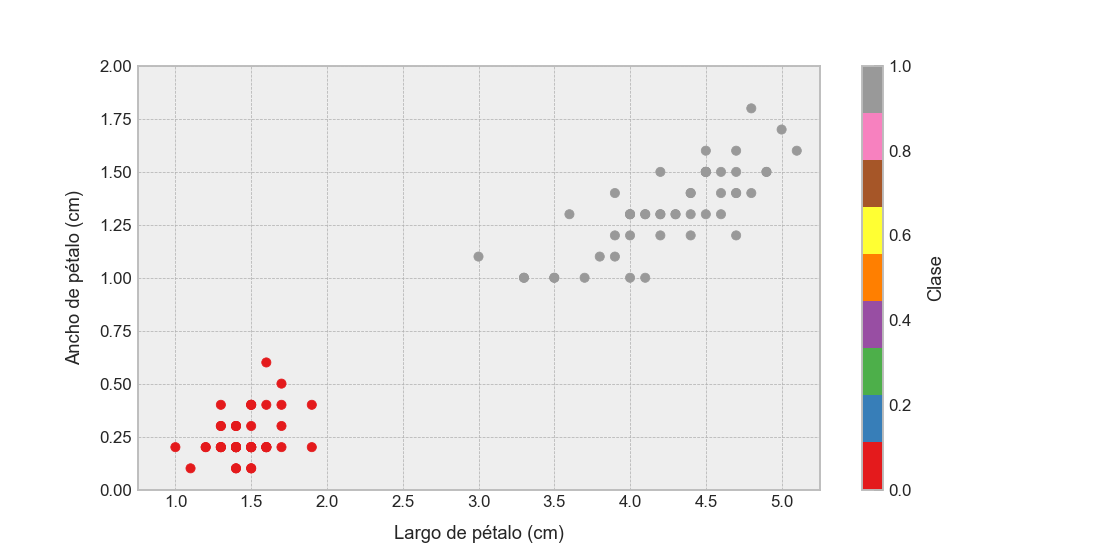

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))
p = ax.scatter(X.iloc[:, 2], X.iloc[:, 3], c=y, cmap="Set1")
ax.set_xlabel("Largo de pétalo (cm)", fontsize=12, labelpad=10)
ax.set_ylabel("Ancho de pétalo (cm)", fontsize=12, labelpad=10)
ax.set_xlim(0.75, 5.25)
ax.set_ylim(0, 2)
cb = fig.colorbar(p)
cb.set_label("Clase", fontsize=12, labelpad=10);

Podemos observar que, con respecto únicamente a las variables "largo de pétalo" y "ancho de pétalo", el *toyset* **<font color='forestgreen'>IRIS</font>** es, en efecto, linealmente separable. Existen pues infinitas rectas que permiten aislar cada subespecie de flor Iris a cada lado de las mismas. Por ejemplo, en los siguientes dos bloques de código, mostraremos tres líneas de separación arbitrarias y construida mediante simple inspección del gráfico anterior:

In [11]:
# Algunas fronteras de separación sub-óptimas.
x_range = np.linspace(start=0.0, stop=5.5, num=100)
y1 = -0.2 * x_range + 1.5
y2 = x_range - 1.8
y3 = 0.1 * x_range + 0.5

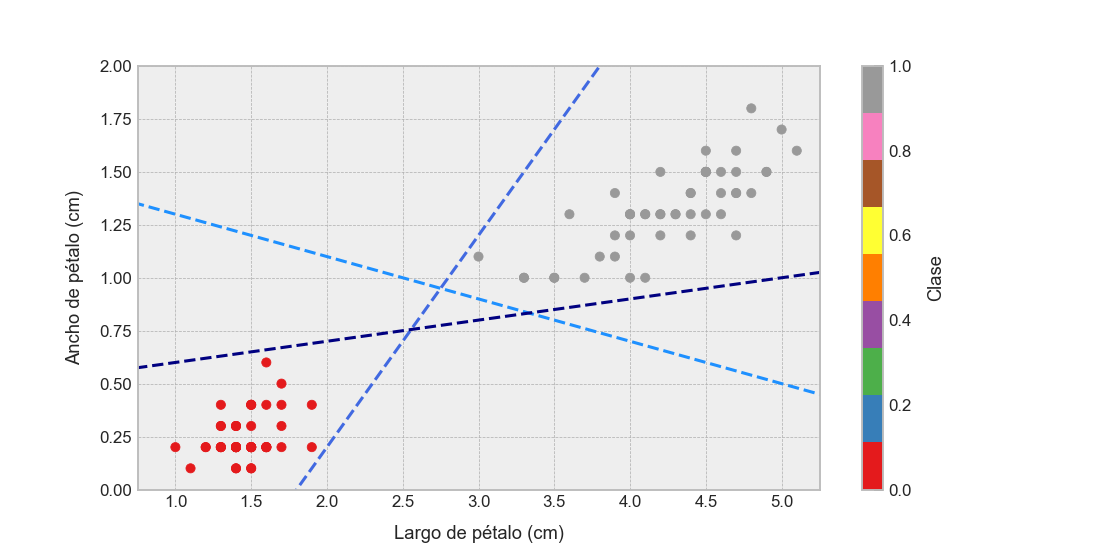

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))
p1 = ax.scatter(X.iloc[:, 2], X.iloc[:, 3], c=y, cmap="Set1")
p2 = ax.plot(x_range, y1, linestyle="--", color="dodgerblue")
p2 = ax.plot(x_range, y2, linestyle="--", color="royalblue")
p2 = ax.plot(x_range, y3, linestyle="--", color="navy")
ax.set_xlabel("Largo de pétalo (cm)", fontsize=12, labelpad=10)
ax.set_ylabel("Ancho de pétalo (cm)", fontsize=12, labelpad=10)
ax.set_xlim(0.75, 5.25)
ax.set_ylim(0, 2)
cb = fig.colorbar(p1)
cb.set_label("Clase", fontsize=12, labelpad=10);

Las tres líneas de separación son válidas, porquen con el objetivo de separar la clase positiva de la clase negativa. Sin embargo, presentan problemas evidentes: Las tres pasan *demasiado cerca* de alguno de los puntos pertenecientes a una determinada clase, lo que puede inducir errores de clasificación cuando tratemos con datos de prueba. Es decir, ninguna de estas líneas es una **frontera óptima de separación**, porque la distancia entre estas líneas y los puntos más cercanos de cada clase a cada una no es la máxima posible.

### El concepto de margen.
En lo que sigue, formalizaremos la noción de frontera óptima de separación introduciendo un nuevo concepto, denominado **margen**, y que es intuitivamente simple: Corresponde a la **distancia** de un hiperplano de separación con respecto a los puntos que representan las instancias más cercanas al mismo, para cada clase, en el dominio donde éstas se encuentran definidas. Formalmente, se tiene pues la siguiente definición.

**<font color='blue'>Definición 5.3 – Margen de separación:</font>** Sea $\mathcal{D} =\left\{ \left( \mathbf{X} ,\mathbf{y} \right)  :\mathbf{X} =\left\{ x_{ij}\right\}  \in \mathbb{R}^{m\times n} \wedge \mathbf{y} \in \mathbb{R}^{m} \right\}$ un conjunto de entrenamiento tal que $\mathbf{y}$ es una variable binaria que puede tomar los valores $-1$ y $+1$ para cada instancia $\mathbf{x}_{i}\in \mathbb{R}^{n}$ de $\mathcal{D}$ (siendo $1\leq i\leq m$). Supongamos que $\mathcal{D}$ es linealmente separable y que el conjunto $\mathcal{H} =\left\{ \mathbf{x} \in \mathbb{R}^{n} :\left< \mathbf{w} ,\mathbf{x} \right>  +b=0\right\}$, para el par de parámetros $\mathbf{w}\in \mathbb{R}^{n}$ y $b\in \mathbb{R}$, define al correspondiente hiperplano de separación entre las clases. Si $\mathbf{x}^{+}$ y $\mathbf{x}^{-}$ son las instancias más cercanas a dicho hiperplano, para las clases positiva y negativa, respectivamente, entonces las distancias $d(\mathcal{H},\mathbf{x}^{+})$ y $d(\mathcal{H},\mathbf{x}^{-})$ serán llamadas **márgenes de separación** asociados al hiperplano $\mathcal{H}$.

De la definición (5.3) podemos observar inmediatamente un problema técnico que puede relativizar enormemente la definición de un margen de separación, y éste radica en la **escala** de los puntos que constituyen el conjunto de entrenamiento $\mathcal{D}$. Dicho de otro modo, si las $n$ variables $\mathbf{x}_{1},\mathbf{x}_{2},\dots,\mathbf{x}_{n}$ tienen órdenes de magnitud distintos, entonces los márgenes de separación correspondientes serán dependientes de tales magnitudes y, por tanto, los cambios de unidades en las variables influirán en las distancias entre las respectivas instancias y los hiperplanos de separación que podamos determinar.

Consideremos un hiperplano de ecuación $\left< \mathbf{w} ,\mathbf{x} \right>  +b=0$ y una instancia arbitraria $\mathbf{x}_{k}\in \mathbb{R}^{m}$ de $\mathcal{D}$. Sin pérdida de generalidad, asumiremos que $\mathbf{x}_{k}$ se encuentra en el *lado positivo* del hiperplano (o, en términos más elegantes, $\left< \mathbf{w} ,\mathbf{x}_{k} \right>  +b>0$). Queremos calcular la distancia $d$ entre el hiperplano y $\mathbf{x}_{k}$. Tomemos la proyección ortogonal de $\mathbf{x}_{k}$ sobre el hiperplano, que llamaremos $\pi_{\mathbf{x}_{k}}$, y que corta al mismo en el punto $\mathbf{x}'_{k}$. Dado que $\mathbf{w}$ es un vector normal al hiperplano, sabemos que la distancia $d$ no es más que un **factor de escalamiento** para $\mathbf{w}$. Si conocemos la *longitud* de $\mathbf{w}$, entonces podemos usar este factor de escalamiento $d$ para determinar la distancia entre $\mathbf{x}_{k}$ y $\mathbf{x}'_{k}$. Por conveniencia, escogemos utilizar un vector de norma unitaria (simplemente dividiendo $\mathbf{w}$ por su norma $\left\Vert \mathbf{w} \right\Vert$). Luego tenemos

$$\mathbf{x}_{k} =\mathbf{x}'_{k} +d\frac{\mathbf{w} }{\left\Vert \mathbf{w} \right\Vert  }$$
<p style="text-align: right;">$(5.8)$</p>

La distancia $d$, conforme la definición (5.3), es en efecto un margen de separación. Queremos pues que el hiperplano de separación sea tal que las instancias de $\mathcal{D}$ pertenecientes a la clase positiva se encuentren a una distancia de, por lo menos, $d$. Mismo caso para las instancias pertenecientes a la clase negativa. El margen $d$ define pues una **función objetivo** que, conforme la ecuación (5.7), satisface la desigualdad

$$\mathbf{y}_{k} \left( \left< \mathbf{w} ,\mathbf{x}_{k} \right>  +b\right)  \geq d$$
<p style="text-align: right;">$(5.9)$</p>

Para todo $k=1,\dots,m$.

Notemos que estamos interesados únicamente en la dirección del vector $\mathbf{w}$, y no en su magnitud, ya que, como dijimos previamente, dicha magnitud dependerá siempre de las magnitudes de las variables de entrada en el conjunto de entrenamiento $\mathcal{D}$. Por lo cual, es común construir un pre-procesamiento de datos que permitan normalizar tales variables. De esta forma, siempre podemos asumir que $\mathbf{w}$ tiene norma (euclidiana) unitaria (esto es, $\left\Vert \mathbf{w} \right\Vert  =\sqrt{\mathbf{w}^{\top } \mathbf{w} } =1$). Este enfoque tiene la ventaja, además, de que el margen $d$ es simplemente un factor de escalamiento aplicado a un vector unitario.

El razonamiento anterior nos permite formular el siguiente problema de optimización, y que será base del modelo SVM:

$$\begin{array}{ll}\displaystyle \max_{\mathbf{w} ,b,d} &\underbrace{d}_{\mathrm{margen} } \\ \mathrm{s.a.:} &\begin{array}{l}\mathbf{y}_{k} \left( \left< \mathbf{w} ,\mathbf{x}_{k} \right>  +b\right)  \geq d\  \left( \mathrm{ajuste\  de\  datos} \right)  \\ \left\Vert \mathbf{w} \right\Vert  =1\  \left( \mathrm{normalizacion} \right)  \\ d>0\  \left( \mathrm{margen\  positivo} \right)  \end{array} \end{array} $$
<p style="text-align: right;">$(5.10)$</p>

Es decir, maximizar el margen $d$, asegurándonos de que los datos residan en los lados correctos con respecto al hiperplano de separación.

### Clasificación con márgenes rígidos.
El problema de optimización (5.10) que subyace el modelo SVM se fundamenta en el hecho de que únicamente estamos interesados en la dirección del vector $\mathbf{w}$ y no en su magnitud, lo que nos lleva al supuesto de que $\left\Vert \mathbf{w} \right\Vert  =1$. Vamos a reformular el problema (5.10) haciendo uso de un enfoque más *tradicional* en el cual, en vez de normalizar el vector $\mathbf{w}$, simplemente introduciremos un **factor de escalamiento** para el conjunto de entrenamiento $\mathcal{D}$ completo. Escogeremos tal factor de manera tal que el predictor $\left< \mathbf{w} ,\mathbf{x} \right>  +b$ sea igual a $1$ para la instancia más cercana al hiperplano de separación. Denotaremos dicha instancia como $\mathbf{x}_{k}$, donde $1\leq k\leq m$, siendo $m$ el total de instancias en el conjunto de entrenamiento $\mathcal{D}$.

<p style="text-align: center;"><img src="figures/fig_5_2.png" width="500"></p>
<p style="text-align: center;">Fig. (5.2): Interpretación geométrica en $\mathbb{R}^{2}$ que permite derivar la fórmula para el margen de separación $d$</p>

La Fig. (5.2) muestra un caso para el cual la instancia $\mathbf{x}_{k}$ reside exactamente sobre el margen de separación. O, equivalentemente, tal que $\left< \mathbf{w} ,\mathbf{x}_{k} \right>  +b=1$. Dado que $\mathbf{x}'_{k}$ es el punto en el hiperplano de separación que se corresponde con la proyección ortogonal de $\mathbf{x}_{k}$ sobre dicho hiperplano, es evidente que

$$\left< \mathbf{w} ,\mathbf{x}^{\prime }_{k} \right>  +b=0$$
<p style="text-align: right;">$(5.11)$</p>

Sustituyendo la ecuación (5.8) en (5.11), obtenemos

$$\left< \mathbf{w} ,\mathbf{x}_{k} -d\frac{\mathbf{w} }{\left\Vert \mathbf{w} \right\Vert  } \right>  +b=0$$
<p style="text-align: right;">$(5.12)$</p>

Dado que el producto interno es bilineal, podemos desarrollar la fórmula (5.12) a fin de obtener

$$\left< \mathbf{w} ,\mathbf{x}_{k} \right>  +b-r\frac{\left< \mathbf{w} ,\mathbf{w} \right>  }{\left\Vert \mathbf{w} \right\Vert  } =0$$
<p style="text-align: right;">$(5.13)$</p>

Debido al escalamiento, se tiene que el término $\left< \mathbf{w} ,\mathbf{x}_{k} \right>  +b$ es igual a 1. Además, como $\left< \mathbf{w} ,\mathbf{w} \right>  =\left\Vert \mathbf{w} \right\Vert^{2}$, la ecuación (5.13) se reduce finalmente a

$$d=\frac{1}{\left\Vert \mathbf{w} \right\Vert  } $$
<p style="text-align: right;">$(5.14)$</p>

Tenemos entonces que el margen de separación depende únicamente del vector $\mathbf{w}$, el cual a su vez es ortogonal al hiperplano de separación. Este resultado puede parecer un tanto contraintuitivo en primera instancia, puesto que, al parecer, hemos desarrollado una fórmula para la distancia $d$ en términos de la magnitud de $\mathbf{w}$, siendo que aún no conocemos este vector. No obstante, a fin de proseguir, vamos simplemente a aceptar este resultado. Un poco más adelante mostraremos que la elección de un margen $d$ igual a $1$ equivale a que el vector $\mathbf{w}$ sea unitario.

De manera similar a lo que hicimos en la ecuación (5.9), queremos que las instancias que pertenezcan a las clases positiva y negativa residan en el *lado correcto* del hiperplano de separación. Como el margen es igual a $1$, esta condición puede escribirse de manera elegante como

$$y_{i}\left( \left< \mathbf{w} ,\mathbf{x}_{i} \right>  +b\right)  \geq 1$$
<p style="text-align: right;">$(5.15)$</p>

Como queremos maximizar el valor del margen $d$, es claro –nuevamente– que estamos ante un problema de optimización:

$$\begin{array}{ll}\displaystyle \max_{\mathbf{w} ,b} &\displaystyle \frac{1}{\left\Vert \mathbf{w} \right\Vert  } \\ \mathrm{s.a.:} &y_{i}\left( \left< \mathbf{w} ,\mathbf{x}_{i} \right>  +b\right)  \geq 1\  ;\  1\leq i\leq m\end{array} $$
<p style="text-align: right;">$(5.16)$</p>

Donde, como siempre, $m$ representa el número total de instancias en el conjunto de entrenamiento $\mathcal{D}$.

En vez de maximizar el recíproco de la norma del vector $\mathbf{w}$, con frecuencia optamos por invertir dicha función objetivo, lo que resulta en el problema equivalente de minimizar el valor de la norma $\left\Vert \mathbf{w} \right\Vert  $ propiamente tal, sujeto a las mismas condiciones que las explicitadas en la expresión (5.16). Añadimos además una constante de $\frac{1}{2}$ a $\left\Vert \mathbf{w} \right\Vert$ y elevamos el valor de $\left\Vert \mathbf{w} \right\Vert$ al cuadrado, de forma tal que los gradientes resultantes al implementar el método de los multiplicadores de Lagrange para resolver este problema sean mucho más sencillos de calcular (ya que minimizar $\left\Vert \mathbf{w} \right\Vert^{2}$ es equivalente a minimizar $\left\Vert \mathbf{w} \right\Vert$). De esta manera, nuestro problema de optimización toma la forma

$$\begin{array}{ll}\displaystyle \min_{\mathbf{w} ,b} &\displaystyle \frac{1}{2} \left\Vert \mathbf{w} \right\Vert^{2}  \\ \mathrm{s.a.:} &y_{i}\left( \left< \mathbf{w} ,\mathbf{x}_{i} \right>  +b\right)  \geq 1\  ;\  1\leq i\leq m\end{array} $$
<p style="text-align: right;">$(5.17)$</p>

El problema (5.17) se conoce en la teoría del aprendizaje automatizado como **modelo SVM de clasificación con márgenes rígidos**. Se le añade la coletilla de *rígido* al margen de separación por el simple hecho de que esta formulación no permite que existan instancias del conjunto de entrenamiento en un lado incorrecto con respecto al hiperplano de separación (y a su correspondiente clase). Es decir, no se permiten **violaciones de márgenes**. Más adelante veremos que dicha condición puede flexibilizarse cuando el conjunto de entrenamiento $\mathcal{D}$ no es linealmente separable, lo que derivará en un **problema de márgenes blandos**.

**Ejemplo 5.1 – Una implementación de un modelo con márgenes rígidos en Python:** En **<font color='mediumorchid'>Scikit-Learn</font>**, es posible implementar SVMs haciendo uso del módulo `sklearn.svm`. Si el problema de interés es de clasificación, bastará muchas veces con hacer uso de la clase `LinearSVC` (que es el acrónimo de *linear support vector classifier*), ya que será más que suficiente para tratar con cualquier problema de clasificación tal que el conjunto de entrenamiento sea linealmente separable.

Como recién hemos definido el problema (primal) de optimización que subyace a la formulación de una SVM, no entraremos en detalles aún sobre aspectos más técnicos del uso de esta implementación, pero la usaremos igualmente para trazar un margen rígido de separación para el *toyset* **<font color='forestgreen'>IRIS</font>**, entrenando así un modelo que permita discriminar, a partir de las dimensiones de los pétalos de cada flor, si éstas son de la subespecie Setosa o Versicolor. Toda esta información ya había sido aislada previamente, cuando mostramos ejemplos de hiperplanos (subóptimos) de separación para este mismo conjunto de datos, en las variables `X` e `y`, por lo que el proceso de ajuste será más bien sencillo:

In [13]:
from sklearn.svm import LinearSVC

In [14]:
# Nos quedamos únicamente con las variables que describen las dimensiones de los pétalos de cada flor.
X_petals = X[['petal length (cm)', 'petal width (cm)']].copy()

Los modelos de tipo SVM, como veremos más adelante, son factibles de ser regularizados por medio de varios hiperparámetros. Uno de ellos corresponde a $C$, y que abordaremos en detalle más adelante. Dicho hiperparámetro permite darle flexibilidad a nuestro modelo en términos del tamaño del margen de separación.

El clasificador `LinearSVC`, cuando traza el correspondiente hiperplano de separación, permite obtener los parámetros que conforman el vector $\mathbf{w}$ una vez ajustado haciendo uso del atributo `coef_`, y también del parámetro de sesgo $b$, mediante el atributo `intercept_`:

In [15]:
# Instanciamos y entrenamos nuestro modelo.
model = LinearSVC(C=1e100, random_state=42)
model.fit(X_petals, y)

/Users/felipequezada/.local/share/virtualenvs/udd_data_science_lectures-cIJkRdo8/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC(C=1e+100, random_state=42)

In [16]:
# Obtenemos los parámetros que caracterizan al hiperplano de separación.
w = model.coef_[0]
b = model.intercept_[0]

In [17]:
# Mostramos en pantalla los parámetros que caracterizan al hiperplano de separación.
print(f"Valor del vector w: {w}")
print(f"Valor del parámetro de sesgo b: {round(b, 2)}")

Valor del vector w: [0.93014882 1.39557258]
Valor del parámetro de sesgo b: -3.33


Recordemos que, en el hiperplano de separación, se tiene que $\left< \mathbf{w} ,\mathbf{x} \right>  +b=0$. En este ejemplo particular, dado que el conjunto de entrenamiento está definido en un dominio de $\mathbb{R}^{2}$, podemos fácilmente separar en componentes la ecuación de dicho hiperplano, poniendo $\mathbf{w}=(w_{1},w_{2})$ y $\mathbf{x}=(x_{1},x_{2})$, lo que nos da $w_{1}x_{1}+w_{2}x_{2}+b=0$. Por lo tanto, podemos escribir de forma explícita la ecuación del hiperplano como $x_{2}=-\frac{w_{1}}{w_{2}} x_{1}-\frac{b}{w_{2}}$, y describir su recorrido en **<font color='mediumorchid'>Numpy</font>** rápidamente como sigue:

In [18]:
# Describimos el recorrido del hiperplano de separación.
x1 = np.linspace(start=0, stop=5.5, num=100)
x2 = (-w[0] / w[1]) * x1 - b / w[1]

Y ahora construiremos algunas variables para graficar el hiperplano de separación:

In [19]:
# Margen de separación.
d = 1 / w[1]

In [20]:
# Límites positivos y negativos relativos al hiperplano.
positive_bound = x2 + d
negative_bound = x2 - d

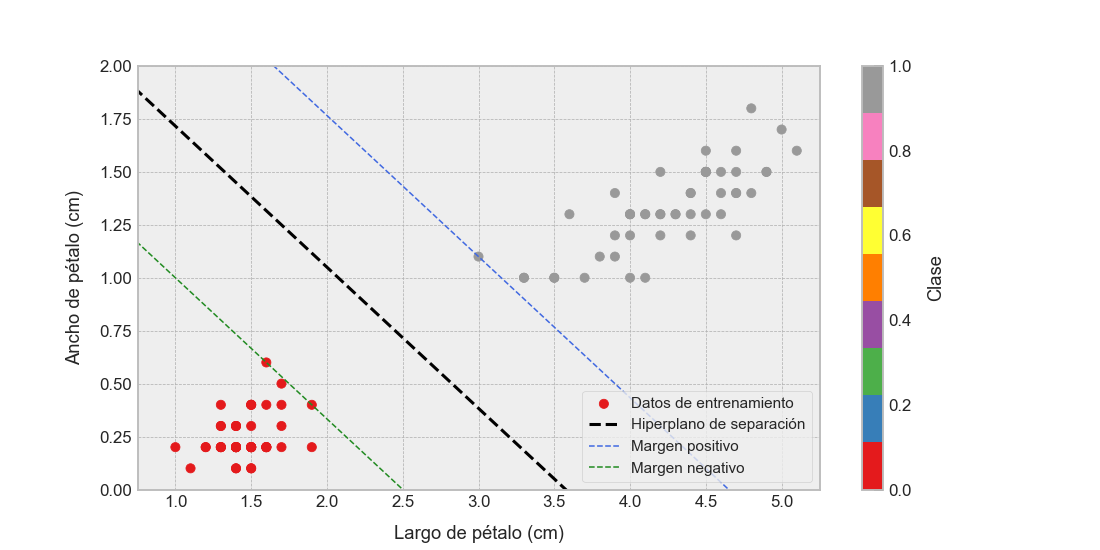

In [21]:
# Graficamos nuestro margen de separación.
fig, ax = plt.subplots(figsize=(10, 5))
p1 = ax.scatter(X.iloc[:, 2], X.iloc[:, 3], c=y, cmap="Set1", label="Datos de entrenamiento")
p2 = ax.plot(x1, x2, color="black", linestyle="--", lw=2, label="Hiperplano de separación")
p3 = ax.plot(x1, positive_bound, color="royalblue", linestyle="--", lw=1, label="Margen positivo")
p4 = ax.plot(x1, negative_bound, color="forestgreen", linestyle="--", lw=1, label="Margen negativo")
ax.set_xlabel("Largo de pétalo (cm)", fontsize=12, labelpad=10)
ax.set_ylabel("Ancho de pétalo (cm)", fontsize=12, labelpad=10)
ax.legend(loc="lower right", fontsize=10, frameon=True)
ax.set_xlim(0.75, 5.25)
ax.set_ylim(0, 2)
cb = fig.colorbar(p1)
cb.set_label("Clase", fontsize=12, labelpad=10);

Y ahí ya tenemos una bonita ilustración de un hiperplano de separación para una SVM, con sus márgenes claramente especificados en cada lado del mismo (positivo y negativo). Notemos que ambos márgenes pasan por los puntos más cercanos al hiperplano de separación. Esto no es un detalle casual, y es algo que abordaremos un poco más adelante. ◼︎

### Una justificación (razonable) de por qué $d=1$.
Previamente hemos establecido, siguiendo dos caminos aparentemente distintos, el problema primal que fundamenta la base de una SVM. En un primer enfoque, definimos que es necesario maximizar la distancia $d$ entre los puntos de cada clase más cercanos al hiperplano de separación. Luego, impusimos la condición de que los datos de entrada debian escalarse, de manera tal que el valor de $d$ siempre fuera igual a 1. Nos esforzaremos pues en justificar la equivalencia de ambos enfoques. Para ello, estableceremos el siguiente teorema.

**<font color='crimson'>Teorema 5.1:</font>** *Sea $\mathcal{D} =\left\{ \left( \mathbf{X} ,\mathbf{y} \right)  :\mathbf{X} =\left\{ x_{ij}\right\}  \in \mathbb{R}^{m\times n} \wedge \mathbf{y} \in \mathbb{R}^{m} \right\}$ un conjunto de entrenamiento tal que $\mathbf{y}$ es una variable binaria que puede tomar los valores $-1$ y $+1$ para cada instancia $\mathbf{x}_{i}\in \mathbb{R}^{n}$ de $\mathcal{D}$ (siendo $1\leq i\leq m$). Admitimos que existe un hiperplano que separa efectivamente ambas clases, cuya ecuación es $\left< \mathbf{w} ,\mathbf{x}_{i} \right>  +b=0$, y con margen igual a $d$. Si $\left\Vert \mathbf{w} \right\Vert  =1$, entonces el problema siguiente, definido por la maximización del margen $d$, tal que*

$$\begin{array}{ll}\displaystyle \max_{\mathbf{w} ,b,d} &\underbrace{d}_{\mathrm{margen} } \\ \mathrm{s.a.:} &\begin{array}{l}y_{i} \left( \left< \mathbf{w} ,\mathbf{x}_{i} \right>  +b\right)  \geq d\  \left( \mathrm{ajuste\  de\  datos} \right)  \\ \left\Vert \mathbf{w} \right\Vert  =1\  \left( \mathrm{normalizacion} \right)  \\ d>0\  \left( \mathrm{margen\  positivo} \right)  \end{array} \end{array} $$
<p style="text-align: right;">$(5.18)$</p>

*es equivalente al escalamiento de la data en $\mathcal{D}$, tal que el margen es unitario. Es decir,*

$$\begin{array}{ll}\displaystyle \min_{\mathbf{w} ,b} &\displaystyle \frac{1}{2} \left\Vert \mathbf{w} \right\Vert^{2}  \\ \mathrm{s.a.:} &y_{i}\left( \left< \mathbf{w} ,\mathbf{x}_{i} \right>  +b\right)  \geq 1\  ;\  1\leq i\leq m\end{array} $$
<p style="text-align: right;">$(5.19)$</p>
◆

Nuestro trabajo ahora será demostrar el teorema (5.1). Para ello, consideraremos el hecho de que maximizar $d^{2}$ es lo mismo que maximizar $d$, debido a que la exponenciación al cuadrado se trata de una transformación que es estrictamente creciente para valores de entrada no negativos. Debido a que $\left\Vert \mathbf{w} \right\Vert  =1$, podemos reparametrizar el problema (5.18) haciendo uso de un nuevo vector $\mathbf{w}'$ cuya norma no sea unitaria, escribiendo explícitamente $\frac{\mathbf{w}^{\prime } }{\left\Vert \mathbf{w}^{\prime } \right\Vert}$. De esta manera obtenemos

$$\begin{array}{ll}\displaystyle \max_{\mathbf{w}^{\prime } ,b,d} &d^{2}\\ \mathrm{s.a.:} &\begin{array}{l}y_{i}\left( \left< \displaystyle \frac{\mathbf{w}^{\prime } }{\left\Vert \mathbf{w}^{\prime } \right\Vert  } ,\mathbf{x}_{i} \right>  +b\right)  \geq d\\ d>0\end{array} \end{array}$$
<p style="text-align: right;">$(5.20)$</p>

La expresión (5.20) establece en forma explícita que la distancia $d$ es positiva. Por lo tanto, podemos dividir la primera restricción por $d$, lo que nos da

$$\begin{array}{ll}\displaystyle \max_{\mathbf{w}^{\prime } ,b,d} &d^{2}\\ \mathrm{s.a.:} &\begin{array}{l}y_{i}\left( \left< \displaystyle \frac{\mathbf{w}^{\prime } }{\left\Vert \mathbf{w}^{\prime } \right\Vert  d} ,\mathbf{x}_{i} \right>  +\displaystyle \frac{b}{d} \right)  \geq 1\\ d>0\end{array} \end{array} $$
<p style="text-align: right;">$(5.21)$</p>

Pongamos $\mathbf{w}^{\prime \prime } =\frac{\mathbf{w}^{\prime } }{\left\Vert \mathbf{w}^{\prime } \right\Vert  d}$ y $b^{\prime \prime }=\frac{b}{d}$. Reordenando nuestros términos, obtenemos

$$\left\Vert \mathbf{w}^{\prime \prime } \right\Vert  =\left\Vert \frac{\mathbf{w}^{\prime } }{\left\Vert \mathbf{w}^{\prime } \right\Vert  d} \right\Vert  =\frac{1}{d} \underbrace{\left\Vert \frac{\mathbf{w}^{\prime } }{\left\Vert \mathbf{w}^{\prime } \right\Vert  } \right\Vert  }_{=1} =\frac{1}{d} $$
<p style="text-align: right;">$(5.22)$</p>

Así que, sustituyendo en la expresión (5.21), obtenemos

$$\begin{array}{ll}\displaystyle \max_{\mathbf{w}^{\prime \prime } ,b^{\prime \prime }} &\displaystyle \frac{1}{\left\Vert \mathbf{w}^{\prime \prime } \right\Vert^{2}  } \\ \mathrm{s.a.:} &y_{i}\left( \left< \mathbf{w}^{\prime \prime } ,\mathbf{x}_{i} \right>  +b^{\prime \prime }\right)  \geq 1\end{array} $$
<p style="text-align: right;">$(5.23)$</p>

Notemos que la maximización de $\frac{1}{\left\Vert \mathbf{w}^{\prime \prime } \right\Vert^{2}  } $ equivale al problema de minimizar $\frac{1}{2} \left\Vert \mathbf{w}^{\prime \prime } \right\Vert^{2}$. Por lo tanto, en efecto, el problema (5.23) es equivalente al problema (5.24), lo que concluye la demostración.

### Clasificación con márgenes blandos.
El problema (5.17) es llamado *problema de márgenes rígidos* porque establece una frontera de separación que no permite que existan instancias localizadas en un lado incorrecto de dicha frontera, siempre que el conjunto de entrenamiento sea linealmente separable. Consideraremos ahora el caso en el cual dicho conjunto de entrenamiento ya no cumple con esta condición. Vale decir, un hiperplano de separación no será suficiente para aislar completamente los puntos que pertenezcan a una clase o a otra, por lo cual admitiremos un cierto nivel de **error** en la clasificación por medio de la existencia de **violaciones del margen de separación**. El problema resultante se denomina **clasificación con márgenes blandos**.

En primera instancia, tal y como hicimos previamente, vamos a derivar el problema (primal) de optimización subyacente a la clasificación con márgenes rígidos basándonos únicamente en una interpretación geométrica, para luego generar una formulación equivalente haciendo uso del concepto bien conocido de **función de costo**, para luego, mediante una aplicación del método de los multiplicadores de Lagrange, obtener una expresión para el correspondiente problema dual, y que a su vez nos permitirá formular una tercera interpretación para el modelo SVM, basada en el concepto de **convexidad**.

<p style="text-align: center;"><img src="figures/fig_5_3.png" width="500"></p>
<p style="text-align: center;">Fig. (5.3): Interpretación geométrica en $\mathbb{R}^{2}$ de un problema de clasificación con márgenes blandos. La instancia $\mathbf{x}_{i}$ se encuentra en el lado incorrecto del hiperplano de separación, y la variable de holgura $\zeta_{i}$ representa la distancia entre la instancia $\mathbf{x}_{i}$ y el margen positivo</p>

La idea principal que sustenta el fundamento geométrico de un problema con márgenes blandos subyace en la adición de una **variable de holgura**, que llamamos $\zeta_{i}$, a cada par $(\mathbf{x}_{i}, y_{i})$ en el conjunto de entrenamiento $\mathcal{D} =\left\{ \left( \mathbf{X} ,\mathbf{y} \right)  :\mathbf{X} =\left\{ x_{ij}\right\}  \in \mathbb{R}^{m\times n} \wedge \mathbf{y} \in \mathbb{R}^{m} \right\}$ ($1\leq i\leq m$). Dicha variable de holgura permite considerar el caso en el cual una instancia particular puede residir sobre el margen de separación o, incluso, en el lado incorrecto del hiperplano de separación, como se observa en la Fig. (5.3). En este caso, restamos el valor de $\zeta_{i}$ del margen, considerandomla restricción $\zeta_{i}\geq 0$ para todo $i=1,\dots,m$. Además, a fin de aumentar la probabilidad de que la clasificación de cada instancia sea correcta, sumamos las variables de holgura a la función objetivo, ponderando dicha suma por un factor $C$, de tal forma que

$$\begin{array}{ll}\displaystyle \max_{\mathbf{w} ,b,\mathbf{\zeta } } &\displaystyle \frac{1}{2} \left\Vert \mathbf{w} \right\Vert^{2}  +C\sum^{m}_{i=1} \zeta_{i} \\ \mathrm{s.a.:} &\begin{array}{l}y_{i}\left( \left< \mathbf{w} ,\mathbf{x}_{i} \right>  +b\right)  \geq 1-\zeta_{i} \\ \zeta_{i} \geq 0\  ;\  1\leq i\leq m\end{array} \end{array}$$
<p style="text-align: right;">$(5.25)$</p>

La expresión (5.25) es llamada **SVM de márgenes blandos**. El hiperparámetro $C>0$ corresponde a un trade-off entre la holgura relativa al margen de separación y el tamaño de dicho margen. Se trata, por tanto, de un **parámetro de regularización**, ya que puede ajustarse convenientemente en cada entrenamiento a fin de ajustar el tamaño del margen, definido en (5.25) por medio del término $\left\Vert \mathbf{w} \right\Vert^{2}$, llamado –en algunos textos especializados– **regularizador**. Un valor grande de $C$ *castiga* o *penaliza* mínimamente las holguras asociadas a las violaciones de margen, dándole más peso a las instancias que no residen en el lado correcto del hiperplano de separación. Luego, un mayor valor de $C$ implica una menor regularización.

La formulación del problema con márgenes blandos (5.25) explicita un **término regularizador** para $\mathbf{w}$ (que corresponde a $C\sum^{m}_{i=1} \zeta_{i}$), pero no uno para el parámetro de sesgo $b$. Desde un aspecto teórico, esto puede representar un problema, y que abordaremos más adelante reformulando el problema (5.25) sobre la base de una función de costo.

### Función de costo de Hinge.
Consideremos un enfoque diferente para derivar el problema subyacente al modelo de clasificación con márgenes blandos, tomando como base el principio de minimización de riesgo empírico. De esta manera, para un modelo de tipo SVM, definimos como conjunto de hipótesis a todos los posibles hiperplanos admisibles de construir a partir del par $(\mathbf{w}, b)$. Es decir,

$$f\left( \mathbf{x} \right)  =\left< \mathbf{w} ,\mathbf{x} \right>  +b$$
<p style="text-align: right;">$(5.26)$</p>

Sin embargo, definir la **función de costo** no resulta tan trivial. Y eso es debido a la naturaleza del problema original que estamos intentando resolver, que corresponde a uno de clasificación. Sea pues $\mathcal{D} =\left\{ \left( \mathbf{X} ,\mathbf{y} \right)  :\mathbf{X} =\left\{ x_{ij}\right\}  \in \mathbb{R}^{m\times n} \wedge \mathbf{y} \in \mathbb{R}^{m} \right\}$ un conjunto de entrenamiento tal que $\mathbf{y}$ es una variable binaria que puede tomar los valores $-1$ y $+1$ para cada instancia $\mathbf{x}_{i}\in \mathbb{R}^{n}$ de $\mathcal{D}$ (siendo $1\leq i\leq m$). Consideremos el error derivado de una predicción realizada por la SVM para una instancia $i$, definida a su vez conforme la ecuación (5.26) como $f(\mathbf{x}_{i})$, y el valor $y_{i}$. Sabemos que la función de costo debe describir el error cometido por el modelo sobre los datos del conjunto de entrenamiento, por lo que, conforme las restricciones del problema de optimización con márgenes rígidos (5.17), podemos escribir

$$\ell \left( \mathbf{x}_{i} |\mathbf{w} ,b\right)  =\max_{\mathbf{w} ,b} \left( 0,1-y_{i}f\left( \mathbf{x}_{i} \right)  \right)  $$
<p style="text-align: right;">$(5.27)$</p>

Reemplazando la ecuación (5.26) en (5.27), obtenemos finalmente la expresión del costo del modelo para la instancia $i$,

$$\ell \left( \mathbf{x}_{i} |\mathbf{w} ,b\right)  =\max_{\mathbf{w} ,b} \left( 0,1-y_{i}\left( \left< \mathbf{w} ,\mathbf{x}_{i} \right>  +b\right)  \right)$$
<p style="text-align: right;">$(5.28)$</p>

Sea $t_{i}=y_{i}\left( \left< \mathbf{w} ,\mathbf{x}_{i} \right>  +b\right)  $. Notemos que, si $f(\mathbf{x}_{i})$ reside en el lado correcto del hiperplano de separación (basándonos, naturalmente, en la etiqueta $y_{i}$), a una distancia $d$ mayor que 1 del mismo, entonces $t_{i}\geq 1$, por lo que el costo subsecuente es cero. Por otro lado, si $f(\mathbf{x}_{i})$ reside igualmente en el lado correcto del hiperplano, pero muy cerca de él (donde *"muy cerca"* significa que $0<t_{i}<1$), entonces la instancia $\mathbf{x}_{i}$ reside dentro del margen de separación y, por lo tanto, el costo correspondiente será positivo. Finalmente, si $f(\mathbf{x}_{i})$ reside en el lado incorrecto del hiperplano (lo que implica que $t_{i}<0$), entonces el costo correspondiente será incluso mayor, e incrementará linealmente con respecto a la distancia $d$ entre la instancia $\mathbf{x}_{i}$ y el hiperplano. En otras palabras, penalizamos todas las instancias que estrán dentro del margen de separación, siendo ésta directamente proporcional a la distancia entre éstas y el hiperplano cuando se encuentran en el lado incorrecto del mismo.

Esta función de costo es muy conocida en la teoría del aprendizaje automático clásico, por lo que, previo a continuar, estableceremos la siguiente definición.

**<font color='blue'>Definición 5.4 – Función de costo de Hinge:</font>** Consideremos un problema de clasificación binario arbitrario caracterizado por un conjunto de entrenamiento $\mathcal{D} =\left\{ \left( \mathbf{X} ,\mathbf{y} \right)  :\mathbf{X} =\left\{ x_{ij}\right\}  \in \mathbb{R}^{m\times n} \wedge \mathbf{y} \in \mathbb{R}^{m} \right\}$, tal que $\mathbf{y}$ es una variable binaria que puede tomar los valores $-1$ y $+1$ para cada instancia $\mathbf{x}_{i}\in \mathbb{R}^{n}$ de $\mathcal{D}$ (siendo $1\leq i\leq m$). Para cada instancia $\mathbf{x}_{i}$ y un predictor $f:\mathcal{D}\longrightarrow \mathbb{R}$ con resultado $t_{i}=f(\mathbf{x}_{i})$, se define la **función de costo de Hinge** como

$$\ell \left( t_{i}\right)  =\max \left( 0,1-t_{i}\right)  $$
<p style="text-align: right;">$(5.29)$</p>

Una forma alternativa de expresar la función de costo de Hinge es mediante la fragmentación de la ecuación (5.29) como

$$\ell \left( t_{i}\right)  =\begin{cases}0&;\  \mathrm{si} \  t_{i}\geq 1\\ 1-t_{i}&;\  \mathrm{si} \  t_{i}<1\end{cases}$$
<p style="text-align: right;">$(5.30)$</p>

Y que puede construirse en Python de manera sencilla:

In [22]:
# Definimos la función de costo de Hinge.
def hinge_loss(t):
    return np.where(t < 1, 1 - t, 0)

In [23]:
# Obtenemos los valores para esta función de costo.
t = np.linspace(start=-4, stop=6, num=100)
l = hinge_loss(t)

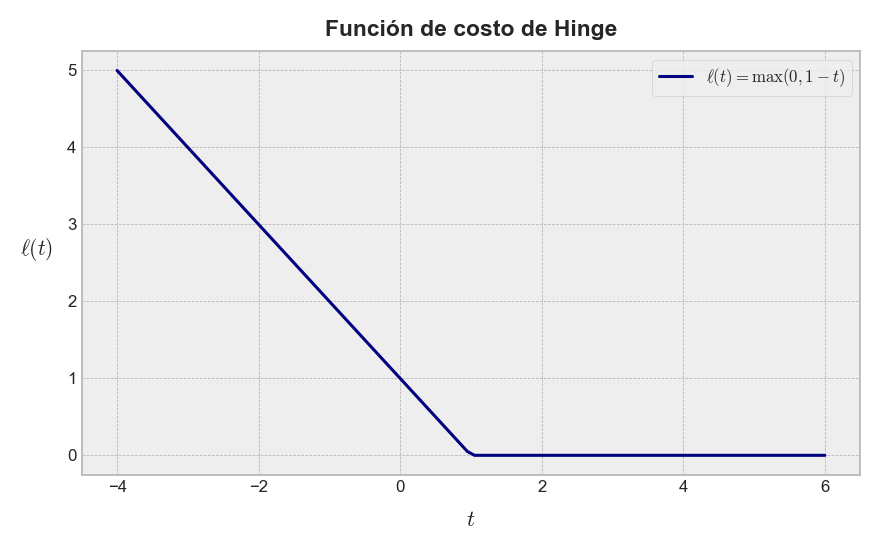

In [24]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(t, l, color="navy", lw=2, label=r"$\ell(t)=\max(0,1-t)$")
ax.legend(loc="upper right", frameon=True)
ax.set_xlabel(r"$t$", fontsize=15, labelpad=10)
ax.set_ylabel(r"$\ell(t)$", fontsize=14, labelpad=20, rotation=0)
ax.set_title("Función de costo de Hinge", fontsize=15, fontweight="bold", pad=10)
plt.tight_layout();

Para el conjunto de entrenamiento $\mathcal{D}$, buscamos minimizar el valor total de la función de costo, que corresponde a la suma total de los costos para cada una de las instancias $\mathbf{x}_{i}$ de $\mathcal{D}$, al mismo tiempo que añadimos un término de costo regularizado de tipo $\ell_{2}$ a la función objetivo. Por lo tanto, usando la función de costo de Hinge, llegamos al siguiente problema de optimización no restringido,

$$\begin{array}{ll}\displaystyle \min_{\mathbf{w} ,b} &\underbrace{\displaystyle \frac{1}{2} \left\Vert \mathbf{w} \right\Vert^{2}  }_{\mathrm{regularizador} } +\underbrace{C\displaystyle \sum^{m}_{i=1} \max \left( 0,1-y_{i}\left( \left< \mathbf{w} ,\mathbf{x}_{i} \right>  +b\right)  \right)  }_{\mathrm{término\  de\  costo\  (regularizado)} } \end{array} $$
<p style="text-align: right;">$(5.31)$</p>

El término $\frac{1}{2} \left\Vert \mathbf{w} \right\Vert^{2}$ es llamado **regularizador**, mientras que el término $C\sum^{m}_{i=1} \max \left( 0,1-y_{i}\left( \left< \mathbf{w} ,\mathbf{x}_{i} \right>  +b\right)  \right)$ es llamado **término de costo o error**. Recordemos que el término regularizador viene definido precisamente por el margen de separación, por lo cual, con la formulación (5.31), la maximización del margen puede interpretarse asimismo como un problema de regularización (de hiperparámetros).

En primera instancia, el problema no restringido (5.31) puede resolverse directamente mediante la implementación cualquier algoritmo de solución como los estudiados en la [clase 1.6](https://github.com/rquezadac/udd_data_science_lectures/blob/main/PARTE%20I%20-%20Fundamentos%20matem%C3%A1ticos%20elementales/clase_1_6.ipynb). Para ver que los problemas (5.25) y (5.31) son equivalentes, observemos que la función de costo de Hinge puede fragmentarse en dos sub-funciones lineales, dependiendo de si su argumento es menor que 1 o no, como ya se ilustró en la ecuación (5.30). Si aplicamos esta función de costo a una instancia, con su correspondiente etiqueta, representadas ambas por el par $(\mathbf{x}_{i}, y_{i})$ (con $1\leq i\leq m$), obtenemos la ecuación (5.28). Equivalentemente, podemos reemplazar el problema de maximización de la función de costo de Hinge sobre la variable $t_{i}=y_{i}\left( \left< \mathbf{w} ,\mathbf{x}_{i} \right>  +b\right)$ con un problema de minimización de una variable de holgura $\zeta_{i}$ con dos restricciones. En términos matemáticos, tenemos que el problema $\displaystyle \min_{t_{i}} \left[ \max \left( 0,1-t_{i}\right)  \right]$ es equivalente a

$$\begin{array}{ll}\displaystyle \min_{\zeta_{i} ,t_{i}} &\zeta_{i} \\ \mathrm{s.a.:} &\begin{array}{l}\zeta_{i} \geq 0\\ \zeta_{i} \geq 1-t_{i}\end{array} \end{array}$$
<p style="text-align: right;">$(5.32)$</p>

Si sustituimos la expresión (5.32) en (5.31) y aplicamos algo de álgebra sobre las restricciones resultantes, obtenemos exactamente el problema mostrado en (5.25).

**Ejemplo 5.2 – Visualización de una clasificación con márgenes blandos en <font color='mediumorchid'>Scikit-Learn</font>:** Vamos a ilustrar visualmente lo que ocurre al implementar un modelo con márgenes blandos haciendo uso, nuevamente, de la librería **<font color='mediumorchid'>Scikit-Learn</font>**. Este ejemplo versará, mayormente, sobre el uso del hiperparámetro $C$ que caracteriza al término de error en el problema (5.31) y su efecto a un nivel más práctico.

Cuando creamos un modelo de SVM utilizando **<font color='mediumorchid'>Scikit-Learn</font>** por medio de la clase `LinearSVC` (que, como vimos antes, es provista por el módulo `sklearn.svm`), podemos especificar varios argumentos para instanciar dicho modelo, entre los cuales se destaca el hiperparámetro `C`. En efecto, se trata de un **parámetro de regularización** que penaliza los costos asociados a las instancias que residen en el lado incorrecto del hiperplano de separación, de forma inversamente proporcional a su magnitud, haciendo uso de una norma determinada a su vez por el hiperparámetro `penalty`, y que naturalmente puede ser `"l1"`, o`"l2"`. Por defecto, **<font color='mediumorchid'>Scikit-Learn</font>** setea este valor en `C=1.0` con una penalización con norma `"l2"`, pero podemos reducirlo para darle menos peso a tales instancias incorrectas, reduciendo los márgenes del modelo y, por tanto, aumentando su nivel de regularización.

Es posible, además, setear el hiperparámetro Booleano `dual`, el cual permite seleccionar el algoritmo que resolverá el problema de optiización inherente a nuestro modelo. En **<font color='mediumorchid'>Scikit-Learn</font>**, la elección de este algoritmo dependerá fundamentalmente de las dimensiones del conjunto de entrenamiento (basadas en el número de instancias y atributos del mismo, $m$ y $n$) y el tipo de penalización seleccionada para las instancias que residan en el lado incorrecto del hiperplano de separación. De este modo, pondremos `dual=False` cuando $m>n$. Siempre podemos forzar a **<font color='mediumorchid'>Scikit-Learn</font>** a tomar esta decisión seteando este parámetro como `dual="auto"`.

Finalmente, debemos setear la función de costo a utilizar por nuestro modelo haciendo uso del parámetro `loss`. Por supuesto, debido a que queremos implementar la función de costo de Hinge como base de nuestro modelo, lo setearemos en `loss="hinge"`:

In [25]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

In [26]:
# Definimos nuestro conjunto de entrenamiento en la forma (X, y).
X = iris["data"][['petal length (cm)', 'petal width (cm)']].values
y = iris["target"] == 2

Como ya hemos observado, las SVMs son sensibles al escalamiento de los datos de entrenamiento, ya que este proceso influye directamente en el tamaño del margen de separación. Por lo tanto, siempre será un procedimiento estándar el normalizar nuestros datos previo al entrenamiento de un modelo de este tipo:

In [27]:
# Normalizamos nuestros datos.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

La implementación de las SVMs en **<font color='mediumorchid'>Scikit-Learn</font>** es intuitiva y fácil de utilizar, pero tiene la desventaja de tener un tiempo de ejecución potencialmente lento, ya que, como veremos más adelante, no es particularmente trivial la resolución del problema de optimización inherente a este modelo. Por eso, suele ser una buena idea controlar el número máximo de iteraciones del algoritmo de solución mediante el parámetro `max_iter`:

In [28]:
# Instanciamos nuestros modelos.
model_1 = LinearSVC(loss="hinge", C=1.0, max_iter=5000, dual="auto", random_state=7)
model_2 = LinearSVC(loss="hinge", C=100, max_iter=5000, dual="auto", random_state=7)

In [29]:
# Entrenamos nuestros modelos.
model_1.fit(X_scaled, y)
model_2.fit(X_scaled, y)

LinearSVC(C=100, dual='auto', loss='hinge', max_iter=5000, random_state=7)

En **<font color='mediumorchid'>Scikit-Learn</font>**, muchos modelos disponen del método `decision_function()`, y que –como su nombre lo indica– permiten evaluar la **función de decisión** asociada a tales modelos en determinadas instancias de un conjunto de datos. Naturalmente, esta función de decisión dependerá de nuestro modelo, pero suele ser consistente con las funciones de hipótesis que se derivan del principio de minimización de riesgo empírico. En el caso de la clase `LinearSVC`, que hace referencia a una SVM que traza fronteras de decisión en la forma de hiperplanos, la función de decisión corresponde a la ecuación que describe dicho hiperplano. Por lo tanto, podemos extraer rápidamente la ecuación del hiperplano de separación haciendo uso de este método (teniendo cuidado de considerar el efecto del escalamiento):

In [30]:
# Usamos la función de decisión de nuestro modelo para determinar los parámetros asociados a los hiperplanos
# de separación correspondientes, aplicando igualmente una de-normalización.
b1 = model_1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = model_2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = model_1.coef_[0] / scaler.scale_
w2 = model_2.coef_[0] / scaler.scale_

In [31]:
# Describimos el recorrido del hiperplano de separación.
x11 = np.linspace(start=1, stop=7, num=100)
x21 = np.linspace(start=1, stop=7, num=100)
x12 = (-w1[0] / w1[1]) * x11 - b1 / w1[1]
x22 = (-w2[0] / w2[1]) * x21 - b2 / w2[1]

In [32]:
# Margen de separación.
d1 = 1 / w1[1]
d2 = 1 / w2[1]

In [33]:
# Límites positivos y negativos relativos al hiperplano.
positive_bound_1 = x12 + d1
positive_bound_2 = x22 + d2
negative_bound_1 = x12 - d1
negative_bound_2 = x22 - d2

Y ya estamos listos para graficar nuestros resultados:

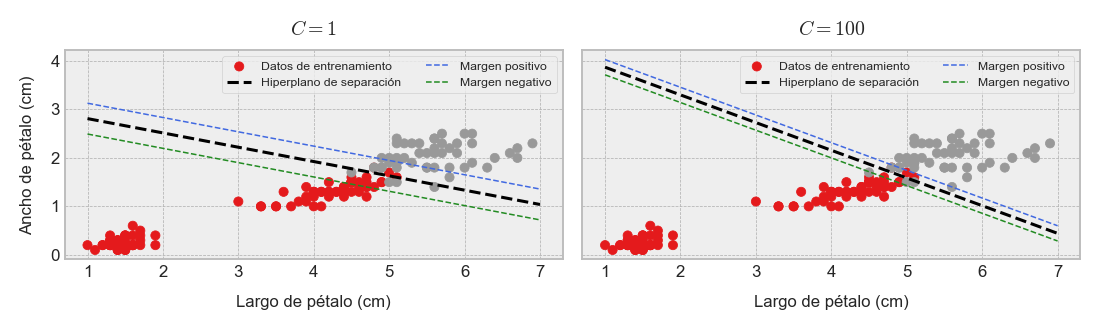

In [34]:
# Graficamos nuestro margen de separación.
fig, ax = plt.subplots(ncols=2, figsize=(10, 3), sharey=True)

p1 = ax[0].scatter(X[:, 0], X[:, 1], c=y, cmap="Set1", label="Datos de entrenamiento")
p2 = ax[0].plot(x11, x12, color="black", linestyle="--", lw=2, label="Hiperplano de separación")
p3 = ax[0].plot(x11, positive_bound_1, color="royalblue", linestyle="--", lw=1, label="Margen positivo")
p4 = ax[0].plot(x11, negative_bound_1, color="forestgreen", linestyle="--", lw=1, label="Margen negativo")
ax[0].set_xlabel("Largo de pétalo (cm)", fontsize=11, labelpad=10)
ax[0].set_ylabel("Ancho de pétalo (cm)", fontsize=11, labelpad=10)
ax[0].legend(loc="upper right", fontsize=8, frameon=True, ncols=2)
ax[0].set_title(r"$C=1$", fontsize=13, pad=10)

p1 = ax[1].scatter(X[:, 0], X[:, 1], c=y, cmap="Set1", label="Datos de entrenamiento")
p2 = ax[1].plot(x21, x22, color="black", linestyle="--", lw=2, label="Hiperplano de separación")
p3 = ax[1].plot(x21, positive_bound_2, color="royalblue", linestyle="--", lw=1, label="Margen positivo")
p4 = ax[1].plot(x21, negative_bound_2, color="forestgreen", linestyle="--", lw=1, label="Margen negativo")
ax[1].set_xlabel("Largo de pétalo (cm)", fontsize=11, labelpad=10)
ax[1].legend(loc="upper right", fontsize=8, frameon=True, ncols=2)
ax[1].set_title(r"$C=100$", fontsize=13, pad=10)

plt.tight_layout()
#cb = fig.colorbar(p1)
#cb.set_label("Clase", fontsize=12, labelpad=10);

Podemos observar, a partir de los gráficos anteriores, los efectos inmediatos de la regularización de nuestros modelos haciendo uso del hiperparámetro `C`. Cuando este valor es pequeño (`C=1.0`), no se aplica regularización, ya que no *castigamos* a las instancias que residen en el lado incorrecto de la frontera de separación (que, en este ejemplo, es la recta marcada con la línea segmentada negra), lo que resulta en un margen de separación ostensiblemente grande, permitiendo igualmente una mayor cantidad de violaciones del mismo (es decir, clasificaciones incorrectas). Cuando el valor de `C` es muy grande (`C=100.0`), el nivel de regularización aplicado es significativo, lo que resulta en un margen mucho más pequeño, permitiendo muchas menos violaciones del mismo. ◼︎

## Formulación del problema dual.
La descripción del modelo SVM que hemos realizado previamente, en términos de las variables $\mathbf{w}\in \mathbb{R}^{n}$ y $b\in \mathbb{R}$, ha dado como resultado la formulación de un set de problemas de optimización, todos equivalentes, que colectivamente suelen denominarse como **problema primal**. Recordemos que nuestra formulación considera un conjunto de entrenamiento $\mathcal{D} =\left\{ \left( \mathbf{X} ,\mathbf{y} \right)  :\mathbf{X} =\left\{ x_{ij}\right\}  \in \mathbb{R}^{m\times n} \wedge \mathbf{y} \in \mathbb{R}^{m} \right\}$. Debido a que el vector $\mathbf{w}$ tiene la misma dimensión que las $m$ instancias de entrenamiento $\mathbf{x}_{i}\in \mathbb{R}^{n}$ (para $1\leq i\leq m$), esto significa que el número de parámetros a estimar por el modelo (las componentes de $\mathbf{w}$) en el problema (5.31) crece linealmente con el número de variables del mismo.

A continuación, consideraremos una nueva formulación completamente equivalente al problema primal, derivando el **problema de optimización dual** asociado, y que es independiente al número de variables del mismo. En el caso del problema dual, el número de parámetros a estimar por el modelo incrementa linealmente con el número de instancias en el conjunto de entrenamiento. Esto resulta útil para el caso de problemas cuyo número de variables excede el número de instancias observadas, aunque, la razón esencial por la que derivaremos el problema dual, es porque, como veremos más adelante, nos permitirá aplicar un artificio matemático extremadamente útil para implementar SVMs en conjuntos de datos que no son linealmente separables.

### Problema dual vía multiplicadores de Lagrange.
Consideremos el problema primal

$$\begin{array}{ll}\displaystyle \max_{\mathbf{w} ,b,\mathbf{\zeta } } &\displaystyle \frac{1}{2} \left\Vert \mathbf{w} \right\Vert^{2}  +C\sum^{m}_{i=1} \zeta_{i} \\ \mathrm{s.a.:} &\begin{array}{l}y_{i}\left( \left< \mathbf{w} ,\mathbf{x}_{i} \right>  +b\right)  \geq 1-\zeta_{i} \\ \zeta_{i} \geq 0\  ;\  1\leq i\leq m\end{array} \end{array}$$
<p style="text-align: right;">$(5.33)$</p>

el cual fue formulado previamente en función de una colección de variables de holgura asociadas a cada instancia de entrenamiento, y que denominamos como $\zeta_{i}$ (para $1\leq i\leq m$). Llamaremos a $\mathbf{w},b$ y $\zeta_{i}$ **variables primales** del modelo SVM, y aplicaremos el método de los multiplicadores de Lagrange para obtener el correspondiente problema dual. Asociaremos pues el multiplicador $\lambda_{i}\geq 0$ a cada una de las restricciones del tipo $y_{i}\left( \left< \mathbf{w} ,\mathbf{x}_{i} \right>  +b\right)  \geq 1-\zeta_{i}$, y que se corresponden con las variables de holgura $\zeta_{i}$ que intentan mantener una clasificación correcta de las instancias de entrenamiento; y el multiplicador $\gamma_{i}$ a las restricciones que garantizan la no negatividad de las variables de holgura. De este modo, el lagrangiano asociado al problema (5.33) toma la forma

$$\mathcal{L} \left( \mathbf{w} ,b,\zeta ,\lambda ,\gamma \right)  =\displaystyle \frac{1}{2} \left\Vert \mathbf{w} \right\Vert^{2}  +C\sum^{m}_{i=1} \zeta_{i} -\underbrace{\sum^{m}_{i=1} \lambda_{i} \left( y_{i}\left( \left< \mathbf{w} ,\mathbf{x}_{i} \right>  +b\right)  -1+\zeta_{i} \right)  }_{\mathrm{clasificacion\  hecha\  correctamente} } -\underbrace{\displaystyle \sum^{m}_{i=1} \gamma_{i} \zeta_{i} }_{\mathrm{holguras\  no\  negativas} }$$
<p style="text-align: right;">$(5.34)$</p>

Calculando las derivadas parciales del lagrangiano (5.34) obtenemos

$$\begin{array}{l}\displaystyle \frac{\partial \mathcal{L} }{\partial \mathbf{w} } =\mathbf{w}^{\top } -\sum^{m}_{i=1} \lambda_{i} y_{i}\mathbf{x}^{\top }_{i} \\ \displaystyle \frac{\partial \mathcal{L} }{\partial b} =-\sum^{m}_{i=1} \lambda_{i} y_{i}\\ \displaystyle \frac{\partial \mathcal{L} }{\partial \zeta_{i} } =C-\lambda_{i} -\gamma_{i} \end{array} $$
<p style="text-align: right;">$(5.35)$</p>

Ahora procedemos a determinar el máximo del lagrangiano anulando las derivadas parciales anteriores. De esta manera, igualando $\frac{\partial \mathcal{L} }{\partial \mathbf{w} }$ a cero, obtenemos

$$\mathbf{w} =\sum^{m}_{i=1} \lambda_{i} y_{i}\mathbf{x}_{i}$$
<p style="text-align: right;">$(5.36)$</p>

La ecuación (5.36) es un caso particular de un resultado que, en la teoría de machine learning, se conoce como [**teorema del representante**](https://en.wikipedia.org/wiki/Representer_theorem), y que, en términos muy generales, establece que la expresión $f^{\ast}$ que minimiza una función que representa el riesgo empírico asociado a una clase o hipótesis dada, puede representarse siempre por medio de una combinación lineal finita de funciones evaluadas en las instancias de entrenamiento. De este modo, la ecuación (5.36) establece que la solución óptima $\mathbf{w}^{\ast}$ del problema primal equivale a una combinación lineal de las instancias $\mathbf{x}_{i}$ (para $1\leq i\leq m$), por lo que, del álgebra lineal, sabemos que tal solución óptima reside en el subespacio vectorial generado por las instancias de entrenamiento.

El teorema del representante, del cual se observa el caso particular (5.36), también establece la razón por la cual este modelo se llama *máquina de soporte vectorial*. Las instancias $\mathbf{x}_{i}$ del conjunto de entrenamiento $\mathcal{D}$ tales que los multiplicadores $\lambda_{i}$ son iguales a cero no contribuyen a la solución óptima $\mathbf{w}^{\ast}$ de ningún modo, mientras que las instancias $\mathbf{x}_{i}$ tales que $\lambda_{i}>0$ son llamadas **vectores de soporte**, ya que el hiperplano de separación pasa por tales instancias y, por tanto, decimos que éstas *"soportan"* a dicho hiperplano.

Sustituyendo la expresión para $\mathbf{w}$ en el lagrangiano (5.34), obtenemos

$$\mathcal{T} \left( \zeta ,\lambda ,\gamma \right)  =\displaystyle \frac{1}{2} \sum^{m}_{i=1} \sum^{m}_{s=1} y_{i}y_{s}\lambda_{i} \lambda_{s} \left< \mathbf{x}_{i} ,\mathbf{x}_{s} \right>  -\sum^{m}_{i=1} y_{i}\lambda_{i} \left< \sum^{m}_{s=1} y_{s}\lambda_{s} \mathbf{x}_{s} ,\mathbf{x}_{i} \right>  +C\sum^{m}_{i=1} \zeta_{i} -b\sum^{m}_{i=1} y_{i}\lambda_{i} +\sum^{m}_{i=1} \lambda_{i} -\sum^{m}_{i=1} \lambda_{i} \zeta_{i} -\sum^{m}_{i=1} \gamma_{i} \zeta_{i} $$
<p style="text-align: right;">$(5.37)$</p>

que corresponde al correspondiente lagrangiano dual de (5.34). Notemos que la ecuación (5.37) ha quedado completamente desprovista de términos que involucren a $\mathbf{w}$. Si igualamos la derivada $\frac{\partial \mathcal{L} }{\partial b}$ a cero, obtenemos $\sum^{m}_{i=1} \lambda_{i}y_{i} =0$. Por lo tanto, el término que incluye a $b$ en (5.37) también desaparece. 

Consideremos los primeros dos sumandos en el lagrangiano dual (5.34). Si aplicamos la propiedad de bilinealidad del producto interno usual en $\mathbb{R}^{n}$, podremos notar que tales sumandos son exactamente iguales con excepción del factor $\frac{1}{2}$, sólo debemos intercambiar los argumentos que se imputan al correspondiente producto interno. De esta manera, el lagrangiano dual se reduce a

$$\mathcal{T} \left( \zeta ,\lambda ,\gamma \right)  =-\frac{1}{2} \sum^{m}_{i=1} \sum^{m}_{s=1} y_{i}y_{s}\lambda_{i} \lambda_{s} \left< \mathbf{x}_{i} ,\mathbf{x}_{s} \right>  +\sum^{m}_{i=1} \lambda_{i} +\sum^{m}_{i=1} \left( C-\lambda_{i} -\gamma_{i} \right)  \zeta_{i} $$
<p style="text-align: right;">$(5.38)$</p>

El último término en la ecuación (5.38) es una colección de todos los términos que contienen variables de holgura $\zeta_{i}$. Igualando ahora la(s) derivada(s) $\frac{\partial \mathcal{L} }{\partial \zeta_{i} } $ a cero, obtenemos que $C-\lambda_{i} -\gamma_{i} =0$ para todo $i=1,\dots,m$. Por lo tanto, el último sumando en (5.38) es también igual a cero. Además, debido a que los multiplicadores $\gamma_{i}$ son no negativos, podemos concluir que $\lambda_{i}\leq C$. De este modo, podemos escribir el problema dual exclusivamente en términos de los multipicadores de Lagrange $\lambda_{i}$, invirtiendo el sentido de optimización del lagrangiano dual como sigue

$$\begin{array}{ll}\displaystyle \min_{\mathbf{\lambda } } &\displaystyle \frac{1}{2} \sum^{m}_{i=1} \sum^{m}_{s=1} y_{i}y_{s}\lambda_{i} \lambda_{s} \left< \mathbf{x}_{i} ,\mathbf{x}_{s} \right>  -\sum^{m}_{i=1} \lambda_{i} \\ \mathrm{s.a.:} &\begin{array}{l}\displaystyle \sum^{m}_{i=1} \lambda_{i} y_{i}=0\\ 0\leq \lambda_{i} \leq C\  ;\  \forall i=1,...,m\end{array} \end{array} $$
<p style="text-align: right;">$(5.39)$</p>

La restricción de igualdad en el problema (5.39) se obtiene a partir de igualar la derivada $\frac{\partial \mathcal{L} }{\partial b}$ a cero, mientras que la restricción de desigualdad $\lambda_{i}\geq 0$ para todo $i=1,...,m$ se impuso originalmente a todos los multiplicadores de Lagrange asociados a las restricciones de desigualdad del problema primal.

El conjunto de restricciones de desigualdad del modelo SVM en (5.39) se conoce como *"restricciones de caja o borde"*, debido a que éstas limitan el vector $\mathbf{\lambda}=(\lambda_{1},...,\lambda_{m})^{\top}\in \mathbb{R}^{m}$ de multiplicadores de Lagrange a que los valores de sus componentes estén dentro de una "caja" $m$-dimensional, estando cada *hiperarista* de la caja limitada por un intervalo del tipo $[0, C]$.

Una vez que obtenemos los parámetros $\lambda_{1},...,\lambda_{m}$, podemos "recuperar" los parámetros $w_{1},...,w_{m}$ aglutinados en el vector $\mathbf{w}\in \mathbb{R}^{m}$ haciendo uso de la ecuación (5.36). Sin embargo, aún queda la interrogante de cómo determinar el parámetro óptimo $b^{\ast}$. Consideremos una instancia $\mathbf{x}_{i}$ que resida exactamente en la frontera del margen de separación; es decir, $\left< \mathbf{w}^{\ast } ,\mathbf{x}_{i} \right>  +b=y_{i}$. Recordemos que $y_{i}$ puede tomar únicamente los valores $-1$ o $+1$. Por lo tanto, la única incógnita en dicha ecuación es $b$, con lo cual el valor óptimo $b^{\ast}$ es

$$b^{\ast }=y_{i}-\left< \mathbf{w}^{\ast } ,\mathbf{x}_{i} \right>$$
<p style="text-align: right;">$(5.40)$</p>

En una primera instancia, puede ocurrir que no existan instancias que residan exactamente sobre el margen de separación del modelo. Si esto nos pasa, deberíamos calcular el valor de $\left| y_{i}-\left< \mathbf{w}^{\ast } ,\mathbf{x}_{i} \right>  \right|  $ para todos los vectores de soporte, y tomar la mediana de dichos valores como el valor de $b^{\ast}$. Este problema se conoce en la literatura especializada (de manera coloquial) como *conspiración del parámetro de sesgo de las SVMs*.

### Un enfoque basado en el concepto de envolvente convexa.
Vamos a desarrollar un último enfoque para formular el problema de optimización inherente al modelo SVM, y que guarda relación con un concepto conocido en matemáticas como **envolvente convexa**, y que motivaremos partiendo desde la siguiente idea: Dado un conjunto de entrenamiento $\mathcal{D} =\left\{ \left( \mathbf{X} ,\mathbf{y} \right)  :\mathbf{X} =\left\{ x_{ij}\right\}  \in \mathbb{R}^{m\times n} \wedge \mathbf{y} \in \mathbb{R}^{m} \right\}$, donde $\mathbf{y}$ puede tomar únicamente los valores $-1$ y $+1$, queremos construir un conjunto convexo que contenga todas las instancias tales que $y_{i}=+1$ para todo $i=1,...,m$. Tal conjunto será la mencionada envolvente convexa para la clase positiva, y que definiremos formalmente a continuación.

**<font color='blue'>Definición 5.5 – Envolvente convexa:</font>** Consideremos un conjunto de puntos $\left\{ \mathbf{x}_{k} \right\}^{n}_{k=1}  \in U$, donde $U$ es un subconjunto convexo de $\mathbb{R}^{n}$ (es decir, es posible conectar cualquier par de puntos de $U$ mediante rectas cuyas trazas siempre pertenecen a $U$). Las siguientes definiciones de **envolvente convexa** para un subconjunto $X$ de $U$ son equivalentes:

- **(D1):** Es el mínimo conjunto convexo que contiene a $X$.
- **(D2):** Es la intersección de todos los conjuntos convexos que contienen a $X$.
- **(D3):** Es la unión de todos los símplices (análogo en $n$ dimensiones de un triángulo) con vértices en $X$.

Este concepto se ilustra en la Fig. (5.4) para un dominio arbitrario de puntos en $\mathbb{R}^{2}$.

<p style="text-align: center;"><img src="figures/fig_5_4.png" width="400"></p>
<p style="text-align: center;">Fig. (5.4): Un ejemplo de envolvente convexa para un dominio arbitrario en $\mathbb{R}^{2}$. Notemos que algunos puntos se encuentra justamente en la frontera de esta envolvente</p>

La definición (5.5) (o, en realidad, las definiciones...) pueden parecer triviales, pero no lo son en absoluto, así que nos preocuparemos de construir una noción relativa a este importante concepto, partiendo de la llamada **combinación convexa** de puntos en un subespacio. Consideremos pues dos puntos, $\mathbf{x}_{1}$ y $\mathbf{x}_{2}$, en un dominio $T\subset \mathbb{R}^{n}$, y dos pesos asociados a estos puntos, que llamaremos $\lambda_{1}$ y $\lambda_{2}$, tales que $\lambda_{1}+ \lambda_{2}=1$. La ecuación $\lambda_{1}\mathbf{x}_{1}+\lambda_{2}\mathbf{x}_{2}$, por tanto, describe a todos los puntos en la recta que une a $\mathbf{x}_{1}$ con $\mathbf{x}_{2}$. Consideremos el efecto de añadir un tercer punto, digamos $\mathbf{x}_{3}$, con su un peso $\lambda_{3}\geq 0$, tal que ahora $\lambda_{1}+\lambda_{2}+\lambda_{3}=1$. La *combinación convexa* de estos tres puntos genera una región (de hecho, un subespacio vectorial) en $\mathbb{R}^{2}$ que envuelve a todos estos puntos. De esta manera, la *envolvente convexa* de esta combinación es simplemente un triángulo cuyos vértices coinciden con los puntos $\mathbf{x}_{1},\mathbf{x}_{2}$ y $\mathbf{x}_{3}$. A medida que agregamos más y más puntos al dominio $T$, y por supuesto que el número de puntos sobrepase la dimensión de $T$, se tendrá que algunos de esos puntos estarán *dentro* de la envolvente, mientras que otros se corresponderán con los vértices de la misma, tal y como se observa en la Fig. (5.4).

En general, la construcción de una envolvente convexa para un conjunto $T$ de $m$ puntos en $\mathbb{R}^{n}$ requiere siempre de la introducción de pesos $\lambda_{i}\geq 0$ asociados a cada uno de ellos ($1\leq i\leq m$). De esta manera, siempre es posible describir a una envolvente convexa como el conjunto

$$\mathrm{conv} \left( T\right)  =\left\{ \sum^{m}_{i=1} \lambda_{i} \mathbf{x}_{i} \right\}  $$
<p style="text-align: right;">$(5.41)$</p>

Donde $\sum^{m}_{i=1} \lambda_{i} =1$ y $\lambda_{i}\geq 0$, para todo $i=1,...,m$. Para el caso de un conjunto de entrenamiento que es linealmente separable, si las dos nubes de puntos que se corresponden con las clases positiva y negativa se separan, entonces resulta evidente que las envolventes convexas de tales nubes no se superponen. Dado entonces un conjunto de entrenamiento representado por los pares de entrada-salida $(\mathbf{x}_{1},y_{1}),...,(\mathbf{x}_{m},y_{m})$, sean $X_{+1}$ y $X_{-1}$ las envolventes convexas que aglutinan a todas las instancias tales que $y_{i}=+1$ y $y_{i}=-1$, respectivamente (para $1\leq i\leq m$). Tomemos un punto $\mathbf{p}\in X_{+1}$, tal que $\mathbf{p}$ sea la instancia más cercana posible a $X_{-1}$. Similarmente, hacemos lo mismo en $X_{-1}$ y seleccionamos un punto $\mathbf{q}$ tal que ésta sea la instancia más cercana posible a $X_{+1}$. Definimos el vector resultante de la diferencia entre $\mathbf{p}$ y $\mathbf{q}$ como

$$\mathbf{w}=\mathbf{p}-\mathbf{q}$$
<p style="text-align: right;">$(5.42)$</p>

Debido a que hemos impuesto la condición de que los puntos $\mathbf{p}$ y $\mathbf{q}$ sean las instancias más cercanas a la envolvente convexa asociada a la clase opuesta, es claro que dicha elección equivale a decir que $\mathbf{p}$ y $\mathbf{q}$ son los puntos con la mínima distancia posible entre las clases positiva y negativa en el conjunto de entrenamiento. Por lo tanto, esta condición se corresponde con la minimización de la magnitud del vector $\mathbf{w}$. En términos matemáticos,

$$\mathrm{arg} \min_{\mathbf{w} } \left\Vert \mathbf{w} \right\Vert  =\mathrm{arg} \min_{\mathbf{w} } \left( \frac{1}{2} \left\Vert \mathbf{w} \right\Vert^{2}  \right)  $$ 
<p style="text-align: right;">$(5.43)$</p>

Donde, como antes, hemos cambiado el argumento $\left\Vert \mathbf{w} \right\Vert$ por $\frac{1}{2} \left\Vert \mathbf{w} \right\Vert^{2}$ en el *optimizador*, meramente para asegurarnos una función objetivo con el mismo mínimo global, pero más fácil de tratar. Debido a que $\mathbf{p}\in X_{+1}$, entonces $\mathbf{p}$ puede expresarse como una combinación lineal de todas las instancias del conjunto de entrenamiento que son pertenecientes a la clase positiva. El caso para $\mathbf{q}$ es completamente análogo, por lo cual

$$\mathbf{p} =\sum_{i\in X_{+1}} \lambda^{+}_{i} \mathbf{x}_{i} \wedge \mathbf{q} =\sum_{i\in X_{-1}} \lambda^{-}_{i} \mathbf{x}_{i} $$
<p style="text-align: right;">$(5.44)$</p>

Donde $\lambda^{+}_{i}$ y $\lambda^{-}_{i}$ son los pesos asociados a las instancias que pertenecen a la clase positiva y negativa, respectivamente. Debido a que hemos definido que $\mathbf{w}=\mathbf{p}- \mathbf{q}$, entonces sustituimos las ecuaciones (5.44) en (5.43), lo que nos da la siguiente función objetivo

$$z=\min_{\lambda^{+}_{i} ,\lambda^{-}_{i} } \left( \frac{1}{2} \left\Vert \sum_{i\in X_{+1}} \lambda^{+}_{i} \mathbf{x}_{i} -\sum_{i\in X_{-1}} \lambda^{-}_{i} \mathbf{x}_{i} \right\Vert^{2}  \right)  $$
<p style="text-align: right;">$(5.45)$</p>

Sea $\mathbf{\lambda}$ el vector que aglutina a todos los pesos $\lambda_{i}^{+}$ y $\lambda_{i}^{-}$. A partir de la definición (5.5), requerimos que la suma de estos coeficientes sea igual a 1 en cada envolvente convexa. Es decir,

$$\sum_{i\in X_{+1}} \lambda^{+}_{i} =1\wedge \sum_{i\in X_{-1}} \lambda^{-}_{i} =1$$
<p style="text-align: right;">$(5.46)$</p>

Las sumatorias anteriores implican que

$$\sum^{m}_{i=1} \lambda_{i} y_{i}=0$$
<p style="text-align: right;">$(5.47)$</p>

Ya que, al desarrollar la suma (5.47), se tiene que

$$\begin{array}{lll}\displaystyle \sum^{m}_{i=1} \lambda_{i} y_{i}&=&\displaystyle \sum_{i\in X_{+1}} \left( +1\right)  \lambda^{+}_{i} +\sum_{i\in X_{-1}} \left( -1\right)  \lambda^{-}_{i} \\ &=&\displaystyle \sum_{i\in X_{+1}} \lambda^{+}_{i} -\sum_{i\in X_{-1}} \lambda^{-}_{i} \\ &=&1-1\\ &=&0\end{array} $$
<p style="text-align: right;">$(5.48)$</p>

La función objetivo (5.45) y la restricción (5.47), junto con la condición $\lambda_{i}\geq 0$ para cada $i=1,...,m$, dan como resultado un problema restringido de optimización convexa que, tras aplicar algo de álgebra, podemos notar que es equivalente al problema de márgenes rígidos (5.17) que desarrollamos al principio de nuestro estudio de las SVMs. La filosofía de este enfoque es esencialmente simple: Maximizar la distancia entre las correspondientes envolventes convexas.

Hasta ahora, podría parecer un tanto estéril nuestro esfuerzo de desarrollar un enfoque más *esotérico* para llegar a una formulación equivalente del problema de márgenes rígidos. Pero hay una razón fundamental para ello, y que estriba en la elección de las instancias $\mathbf{p}$ y $\mathbf{q}$ en las envolventes convexas de las clases positiva y negativa, respectivamente. Podemos observar que la función objetivo (5.45), y por extensión el hiperplano de separación, quedan completamente determinados por $\mathbf{p}$ y $\mathbf{q}$. Esto motiva el nombre de tales puntos: **vectores de soporte**. Y, por supuesto, el nombre del modelo: Máquina de soporte vectorial.

## Problemas no linealmente separables.
Los enfoques desarrollados previamente para la construir los problemas de optimización primal y dual que son inherentes a una máquina de soporte vectorial han tenido como único objetivo entender, desde su perspectiva más fundamental, qué hacen estos artilugios matemáticos: Clasificar datos con respecto a ciertas etiquetas o categorías. Para ello, tuvimos que recurrir a fragmentar nuestro estudio en dos partes, abordando primero el caso de la clasificación con márgenes rígidos, donde no se permiten errores de ningún tipo, y luego admitiendo que pueden existir violaciones de los márgenes de separación por medio de la implementación una función de costo especialmente diseñada para ello (función de Hinge). Sin embargo, sólo hemos arañado la superficie, porque en realidad, ninguno de estos enfoques cubre el caso más común al que nos veremos enfrentados en el mundo real, y que es cuando nuestro conjunto de entrenamiento no es linealmente separable.

Sin embargo, como veremos más adelante, no hemos perdido nuestro tiempo. Los desarrollos efectuados previamente contienen todos los ingredientes esenciales para, en efecto, entender cómo una máquina de soporte vectorial puede efectuar clasificaciones con gran precisión en un conjunto de entrenamiento que no admite fronteras de separación lineales. Para ello, vamos a darle un sentido más heurístico a este modelo, y lo segmentaremos en dos procedimientos matemáticos de interés:

- **(P1):** Dado un conjunto de entrenamiento $\mathcal{D} =\left\{ \left( \mathbf{X} ,\mathbf{y} \right)  :\mathbf{X} =\left\{ x_{ij}\right\}  \in \mathbb{R}^{m\times n} \wedge \mathbf{y} \in \mathbb{R}^{m} \right\}$, donde $\mathbf{y}$ puede tomar únicamente los valores $-1$ y $+1$, que denominaremos genéricamente como **espacio o dominio de entrada** del problema, y que sabemos (o, probabemente, asumimos) de antemano que no es linealmente separable, definiremos una aplicación que mapeará todos los elementos de $\mathcal{D}$ sobre un espacio vectorial de dimensión prácticamente infinita, denominado como **espacio o dominio de atributos**, y que de alguna forma estará *oculto* tanto de la entrada como de la salida del modelo.
- **(P2):** En este nuevo dominio de atributos, el problema resultante sí será *linealmente separable*, por lo que procederemos a resolverlo de la manera usual, construyendo un hiperplano de separación con todas las condiciones previamente estudiadas. Los valores obtenidos como resultado del modelo estarán todos definidos en un espacio vectorial denominado **espacio de salida** del modelo.

Esta idea es la que desarrollaremos a continuación, no sin antes mencionar que el dominio de atributos previamente comentado no es un constructo *esotérico* en absoluto. De hecho, el número de atributos que lo caracterizarán será siempre una función del número de vectores de soporte, por lo cual la dificultad del problema radicará en determinar (analíticamente) el tamaño óptimo de este espacio (oculto). Tal idea se ilustra en la Fig. (5.5).

<p style="text-align: center;"><img src="figures/fig_5_5.png" width="900"></p>
<p style="text-align: center;">Fig. (5.5): Ilustración de los dos procedimientos matemáticos que se realizan en una máquina de soporte vectorial para un caso general en el cual el conjunto de entrenamiento no necesariamente es linealmente separable</p>

### Implementación de funciones kernel.
Sea pues $\mathbf{x}_{i}\in \mathbb{R}^{n}$ una instancia del espacio de entrada $\mathcal{D}$, donde $1\leq i\leq m$. Sea $\left\{ \phi_{j} \left( \mathbf{x}_{i} \right)  \right\}^{+\infty }_{j=1}$ una colección (infinita) de funciones no lineales que, entre ellas, *transforman* el espacio de entrada de dimensión $n$ en un **espacio de atributos** de dimensión infinita. Dada esta transformación, podemos definir un hiperplano que hará el trabajo de una frontera de separación por medio de la fórmula

$$\sum^{+\infty }_{j=1} w_{j}\phi_{j} \left( \mathbf{x}_{i} \right)  =0$$
<p style="text-align: right;">$(5.49)$</p>

donde $\left\{ w_{j}\right\}^{+\infty }_{j=1}$ denota a una colección infinita de pesos que tiene como objetivo transformar a nuestro espacio de atributos en el espacio de salida del modelo. Es en este espacio de salida donde se toma la decisión con respecto a la pertenencia de la instancia $\mathbf{x}_{i}$ a la clase positiva o negativa. Sin pérdida de generalidad, vamos a ilustrar el caso para el cual el parámetro de sesgo $b$ es igual a cero. De esta manera, podemos reescribir la ecuación (5.49) en forma matricial como

$$\mathbf{w}^{\top } \mathbf{\phi } \left( \mathbf{x}_{i} \right)  =0$$
<p style="text-align: right;">$(5.50)$</p>

donde $\mathbf{\phi } \left( \mathbf{x}_{i} \right)$ es llamado **vector de atributos**, siendo $\mathbf{w}$ el correspondiente vector que aglutina a los pesos $w_{1},w_{2},...$.

Como antes, estamos interesados en la separabilidad lineal de los puntos en el espacio de atributos. Con este objetivo en mente, podemos adaptar la ecuación (5.36) a nuestra situación actual, por lo que el vector óptimo de pesos $\mathbf{w}^{\ast}$ puede escribirse como

$$\mathbf{w}^{\ast } =\sum^{m_{s}}_{i=1} \lambda_{i} y_{i}\mathbf{\phi } \left( \mathbf{x}_{i} \right)$$
<p style="text-align: right;">$(5.51)$</p>

Donde $m_{s}$ es un contador que únicamente toma en consideración a aquellas instancias tales que $\lambda_{i}>0$ para todo $i=1,...,m$, las cuales, como ya hemos verificado, corresponden a los vectores de soporte del modelo. En la ecuación (5.51), el vector de atributos está expresado de la forma $\mathbf{\phi}(\mathbf{x}_{i})=(\phi_{1}(\mathbf{x}_{i}),\phi_{2}(\mathbf{x}_{i}),...)^{\top}$. Por lo tanto, al sustituir la ecuación (5.50) en (5.51), podemos expresar la **frontera de separación** en el espacio de atributos como

$$\sum^{m_{s}}_{i=1} \lambda_{i} y_{i}\mathbf{\phi }^{\top } \left( \mathbf{x}_{i} \right)  \mathbf{\phi } \left( \mathbf{x} \right)  =0$$
<p style="text-align: right;">$(5.52)$</p>

Podemos observar que el escalar $\mathbf{\phi }^{\top } \left( \mathbf{x}_{i} \right)  \mathbf{\phi } \left( \mathbf{x}_{i} \right)$ en la ecuación (5.32) es, de hecho, un producto interno. Representemos dicho objeto matemático como

$$K\left( \mathbf{x} ,\mathbf{x}_{i} \right)  =\mathbf{\phi }^{\top } \left( \mathbf{x}_{i} \right)  \mathbf{\phi } \left( \mathbf{x}_{i} \right)  =\sum^{+\infty }_{j=1} \phi_{j} \left( \mathbf{x}_{i} \right)  \phi_{j} \left( \mathbf{x} \right)$$
<p style="text-align: right;">$(5.53)$</p>

Siendo $i=1,2,...m_{s}$. Correspondientemente, podemos expresar la frontera de separación en el espacio de salida como

$$\sum^{m_{s}}_{i=1} \lambda_{i} y_{i}K\left( \mathbf{x} ,\mathbf{x}_{i} \right)  =0$$
<p style="text-align: right;">$(5.54)$</p>

La función $K(\mathbf{x},\mathbf{x}_{i})$ es llamada **función kernel** o, simplemente, *kernel*. Esto motiva la siguiente definición.

**<font color='blue'>Definición 5.6 – Kernel:</font>** Sea $\mathcal{D}$ un conjunto no vacío arbitrario. Una función simétrica $K:\mathcal{D}\times \mathcal{D}\longrightarrow \mathbb{R}$ es llamada **kernel** (definido positivo) sobre $\mathcal{D}$ si la desigualdad

$$\sum^{m}_{i=1} \sum^{m}_{j=1} c_{i}c_{j}K\left( \mathbf{x}_{i} ,\mathbf{x}_{j} \right)  \geq 0$$
<p style="text-align: right;">$(5.55)$</p>

es válida para todo $\mathbf{x}_{1},...,\mathbf{x}_{m}\in \mathcal{D}$, dados $m\in \mathbb{N}$ y $c_{1},...,c_{m}\in \mathbb{R}$.

Las funciones kernel tienen varias propiedades importantes, de entre las cuales se desprenden dos de particular importancia (aplicadas para el kernel definido en la ecuación (5.53)):

- **(P1):** Al ser $K$ simétrica, se tiene que $K(\mathbf{x},\mathbf{x}_{i})=K(\mathbf{x}_{i},\mathbf{x})$ para toda instancia $\mathbf{x}_{i}$ en el conjunto de entrenamiento. Además, es posible demostrar que $K$, cuando es una función convexa, alcanza su valor máximo para $\mathbf{x}=\mathbf{x}_{i}$.
- **(P2):** El hipervolumen bajo la gráfica de $K$ es constante. Esto suele describirse matemáticamente como

$$\int_{\Omega } K\left( \mathbf{x} ,\mathbf{x}_{i} \right)  d\mathbf{x} =\mathrm{constante} $$
<p style="text-align: right;">$(5.56)$</p>

Donde $\Omega$ es el dominio de atributos.

Si el kernel $K(\mathbf{x},\mathbf{x}_{i})$ se escala de manera apropiada, de manera tal que la integral (5.56) tenga un valor igual a 1, entonces $K$ tendrá propiedades similares a las de una función de densidad para una variable aleatoria.


### Truco del kernel.
Examinando la ecuación (5.54), podemos hacer dos importantes observaciones:

- En lo que respecta a un problema de clasificación general sobre el espacio de salida, la especificación del kernel $K(\mathbf{x},\mathbf{x}_{i})$ es *suficiente* para resolver dicho problema. En palabras más simples, no necesitamos explicitar el vector $\mathbf{w}^{\ast}$ especificado en la ecuación (5.51). Es por esta razón que la ecuación (5.53) suele denominarse como **truco del kernel**.
- Incluso aunque hemos asumido que el espacio de atributos puede ser de dimensión infinita, la ecuación lineal (5.54), que define la frontera de separación de nuestro modelo, consiste de un número *finito* de términos, y que es igual al número de instancias del conjunto de entrenamiento.

A la luz de lo anterior, suele ser común que en textos especializados se haga referencia a que las máquinas de soporte vectorial sean un caso particular de métodos conocidos como **máquinas kernel**. Para el caso de un problema de clasificación, esta *máquina* particular se parametriza mediante un vector de dimensión $m$ cuyo $i$-ésimo término está definido por el producto $\lambda_{i}y_{i}$ (para $1\leq i\leq m$).

Podemos ver a $K(\mathbf{x}_{i},\mathbf{x}_{j})$ como el $ij$-ésimo elemento de una matriz en $\mathbb{R}^{n\times n}$, definida como

$$\mathbf{K} =\left\{ K\left( \mathbf{x}_{i} ,\mathbf{x}_{j} \right)  \right\}  =\left( \begin{matrix}K\left( \mathbf{x}_{1} ,\mathbf{x}_{1} \right)  &K\left( \mathbf{x}_{1} ,\mathbf{x}_{2} \right)  &\cdots &K\left( \mathbf{x}_{1} ,\mathbf{x}_{n} \right)  \\ K\left( \mathbf{x}_{2} ,\mathbf{x}_{1} \right)  &K\left( \mathbf{x}_{2} ,\mathbf{x}_{2} \right)  &\cdots &K\left( \mathbf{x}_{2} ,\mathbf{x}_{n} \right)  \\ \vdots &\vdots &\ddots &\vdots \\ K\left( \mathbf{x}_{n} ,\mathbf{x}_{1} \right)  &K\left( \mathbf{x}_{n} ,\mathbf{x}_{2} \right)  &\cdots &K\left( \mathbf{x}_{n} ,\mathbf{x}_{n} \right)  \end{matrix} \right)  \in \mathbb{R}^{n\times n} $$
<p style="text-align: right;">$(5.57)$</p>

La matriz $\mathbf{K}$ es semi-definida positiva y simétrica (es decir, $\mathbf{K}=\mathbf{K}^{\top}$), y suele ser denominada como **matriz kernel** o **matriz de Gram**. Por tanto, esta matriz satisface la condición

$$\mathbf{p}^{\top} \mathbf{K} \mathbf{p}\geq 0$$
<p style="text-align: right;">$(5.58)$</p>

para todo vector $\mathbf{p}$ cuya dimensión es compatible con las dimensiones de $\mathbf{K}$.

La inclusión del paso proyectivo que implica la implementación del truco del kernel, por tanto, genera un cambio importante en el problema de optimización que es subyacente a la máquina de soporte vectorial. Tomando todos nuestros resultados anteriores, podemos observar que dicho problema ahora toma la forma

$$\begin{array}{ll}\displaystyle \min_{\lambda } &\displaystyle \frac{1}{2} \sum^{m}_{i=1} \sum^{m}_{s=1} y_{i}y_{s}\lambda_{i} \lambda_{s} K\left( \mathbf{x}_{i} ,\mathbf{x}_{s} \right)  -\sum^{m}_{i=1} \lambda_{i} \\ \mathrm{s.a.:} &\begin{array}{l}\displaystyle \sum^{m}_{i=1} \lambda_{i} y_{i}=0\\ 0\leq \lambda_{i} \leq C\  ;\  \forall i=1,...,m\end{array} \end{array}$$
<p style="text-align: right;">$(5.59)$</p>

Podríamos decir que (5.59) es, sin lugar a dudas, la versión *definitiva* de este problema, y que es apta para cualquier problema de clasificación. Incluso aquellos definidos sobre conjuntos de entrenamiento que no son linealmente separables. Notemos que el problema (5.59) es *casi igual* al problema (5.39). La única diferencia es que hemos cambiado el producto interno $\left< \mathbf{x}_{i} ,\mathbf{x}_{s} \right>  $ por el kernel $K(\mathbf{x}_{i},\mathbf{x}_{s})$.

**Ejemplo 5.3 – Un kernel polinomial:** Vamos a ilustrar como aplicar un **kernel polinomial** sobre un conjunto de entrenamiento con dos atributos o variables independientes, y que podemos escribir como $\mathcal{D}=\left\{ \left( \mathbf{X} ,\mathbf{y} \right)  :\mathbf{X} \in \mathbb{R}^{m\times 2} \wedge \mathbf{y} \in \mathbb{R}^{m} \right\}$, siendo $m$ el número de instancias. Como siempre, $\mathbf{y}$ es una variable binaria que puede tomar los valores $+1$ o $-1$. Para cada instancia $\mathbf{x}_{i}=(x_{i1},x_{i2})$, el kernel polinomial no es más que una transformación que aplica el vector $(x_{i1},x_{i2})\in \mathbb{R}^{2}$ en un espacio vectorial cuya dimensión es dependiente del grado del polinomio de interés. Si el kernel aplica una transformación polinómica de grado 2, entonces las imágenes de esta transformación *vivirán* en $\mathbb{R}^{3}$, porque las *componentes* de la misma serán *múltiplos* de $x_{1}^{2}$, $x_{1}x_{2}$ y $x_{2}^{2}$. Por ejemplo, si la transformación se denota como $\phi$, tenemos que

$$\phi\left( x_{1},x_{2}\right)  =\left( x^{2}_{1},\sqrt{2} x_{1}x_{2},x^{2}_{2}\right)^{\top }\in \mathbb{R}^{3}$$
<p style="text-align: right;">$(5.60)$</p>

Aplicando la ecuación (5.53) para un par de vectores $\mathbf{a}=(a_{1},a_{2})$ y $\mathbf{b}=(b_{1},b_{2})$ de $\mathcal{D}$, obtenemos

$$\begin{array}{lll}\phi \left( \mathbf{a} \right)^{\top }  \phi \left( \mathbf{b} \right)  &=&\left( \begin{matrix}a^{2}_{1}\\ \sqrt{2} a_{1}a_{2}\\ a^{2}_{2}\end{matrix} \right)^{\top }  \left( \begin{matrix}b^{2}_{1}\\ \sqrt{2} b_{1}b_{2}\\ b^{2}_{2}\end{matrix} \right)  \\ &=&a^{2}_{1}b^{2}_{1}+2a_{1}a_{2}b_{1}b_{2}+a^{2}_{2}b^{2}_{2}\\ &=&\left( a_{1}b_{1}+a_{2}b_{2}\right)^{2}  \\ &=&\left( \left( \begin{gathered}a_{1}\\ a_{2}\end{gathered} \right)^{\top }  \left( \begin{gathered}b_{1}\\ b_{2}\end{gathered} \right)  \right)^{2}  \\ &=&\left( \mathbf{a}^{\top } \mathbf{b} \right)^{2}  \end{array}  $$
<p style="text-align: right;">$(5.61)$</p>

Es decir, el producto interno de los vectores transformados es igual a $\left( \mathbf{a}^{\top } \mathbf{b} \right)^{2}$. Este resultado es extremadamente importante, porque si aplicamos la transformación $\phi$ a todas las instancias del conjunto de entrenamiento $\mathcal{D}$, entonces el problema dual subyacente a la máquina de soporte vectorial contendrá el producto interno $K(\mathbf{x}_{i},\mathbf{x}_{s})=\phi^{\top}(\mathbf{x}_{i})\phi(\mathbf{x}_{s})$ para cada par de instancias $\mathbf{x}_{i}$ y $\mathbf{x}_{s}$ de $\mathcal{D}$. Pero si $\phi$ es la transformación polinomial (5.60), entonces podemos reemplazar esta expresión por $\left( \mathbf{x}^{\top }_{i} \mathbf{x}_{s} \right)^{2}$. Por lo tanto, en realidad, no tenemos ninguna necesidad de transformar nuestros datos de entrenamiento mediante la función $\phi$. El resultado al que llegaremos será exactamente el mismo que obtendríamos de, efectivamente, aplicar la transformación $\phi$ a cada uno de los datos de entrenamiento, **con todo el costo computacional que ello implica**. Por esta razón es que la expresión (5.53) es llamada **truco del kernel**, y es extremadamente útil cuando se trata de acelerar la convergencia de un modelo.

La función $K(\mathbf{a},\mathbf{b})=(\mathbf{a}^{\top}\mathbf{b})^{2}$ es llamada **kernel polinomial cuadrático**. Se trata de un caso particular del llamado **kernel polinomial no homogéneo de grado $d$**, que se define como $K(\mathbf{a},\mathbf{b})=(\mathbf{a}^{\top}\mathbf{b}+c)^{d}$, siendo $c\geq 0$ un hiperparámetro que representa el trade-off entre la influencia de los términos de alto y bajo grado en el polinomio resultante. Se trata de un kernel no muy común en problemas de clasificación clásicos (con data de tipo tabular), pero sí muy utilizado en problemas más específicos, como los derivados del **procesamiento del lenguaje natural**, que es un área de las ciencias de la computación dedicada a la creación de modelos que permitan a los computadores el poder *manipular* el lenguaje, acercando un poco a los ordenadores al *entendimiento* del mismo, mas no al verdadero entendimiento (desde una perspectiva ontológica). ◼︎

Existen ciertas condiciones que debe cumplir un kernel $K$ para que exista una función $\phi$ tal que $K(\mathbf{a},\mathbf{b})=\phi^{\top}(\mathbf{a})\phi(\mathbf{b})$, donde $\phi$ aplica los vectores $\mathbf{a}$ y $\mathbf{b}$ en un espacio vectorial de muchas (probablemente infinitas) dimensiones. Tales condiciones se resumen en un importante teorema en el análisis funcional, conocido como **teorema de Mercer** (de hecho, es común que estas condiciones se denominen en la literatura especializada como **condiciones de Mercer**). De acuerdo a este teorema, podemos usar $K$ como un kernel porque sabemos que $\phi$ existe, incluso si no tenemos ni la más mínima idea de la estructura de $\phi$. Esto es realmente una buena noticia, porque si un kernel $K$ implica una transformación intermedia $\phi$ que aplique los vectores de entrada a un espacio de dimensión infinita, el cálculo individual de cada imagen es un problema que, por definición, es intratable.

Vamos a enunciar el teorema de Mercer únicamente con propósitos ilustrativos. No ahondaremos en su demostración ni fundamentos más elementales, a fin de no desviarnos del alcance de esta sección.

**<font color='crimson'>Teorema 5.1 – Condiciones de Mercer:</font>** *Sea $\mathcal{D}$ un conjunto de entrenamiento, con $\mathbf{u}$ y $\mathbf{v}$ instancias de $\mathcal{D}$. Sea $K(\mathbf{u},\mathbf{v})$ un kernel simétrico definido en la celda cerrada $R=\left\{ \mathbf{a} \wedge \mathbf{b} \in \mathcal{D} :\mathbf{a} \leq \mathbf{u} \leq \mathbf{b} \wedge \mathbf{a} \leq \mathbf{v} \leq \mathbf{b} \right\}$. Entonces $K$ puede expandirse por medio de la serie infinita*

$$K\left( \mathbf{u} ,\mathbf{v} \right)  =\sum^{+\infty }_{i=1} \lambda_{i} \phi_{i} \left( \mathbf{u} \right)  \phi_{i} \left( \mathbf{v} \right)$$
<p style="text-align: right;">$(5.62)$</p>

*siendo los $\lambda_{i}$ coeficientes positivos para cada $i$. Para que la expansión (5.62) sea válida y converja absoluta y uniformemente en un determinado dominio, es necesario y suficiente que la desigualdad*

$$\int_{R} K\left( \mathbf{u} ,\mathbf{v} \right)  \psi \left( \mathbf{u} \right)  \psi \left( \mathbf{v} \right)  dR\geq 0 $$
<p style="text-align: right;">$(5.63)$</p>

*se cumpla para toda función $\psi$ tal que ésta es integrable en cualquier subespacio de $R$. Es decir,*

$$\int_{\partial R} \psi^{2} \left( \mathbf{u} \right)  d\mathbf{u} <+\infty  $$
<p style="text-align: right;">$(5.64)$</p>  ◆

En un lenguaje más técnico (y en el dominio del análisis funcional), las funciones $\phi_{i}$ son llamadas **autofunciones** o **funciones características** de la expansión (5.62), mientras que los números reales $\lambda_{i}$ son los autovalores de la matriz de Gram $\mathbf{K}$, definida previamente en (5.57), y que consta de todas las combinaciones posibles $K(\mathbf{u},\mathbf{v})$. Como las condiciones de Mercer exigen que estos autovalores sean no negativos, se desprende que $\mathbf{K}$ es, como ya habíamos comentado, una matriz semi-definida positiva.

Existen varias funciones kernel que son muy utilizadas en la construcción de modelos basados en máquinas de soporte vectorial. Su uso dependerá, en general, de aspectos geométricos inherentes a la estructura del conjunto de entrenamiento en términos de la densidad observada de las instancias que la componen. No es muy común *adivinar* su caso de uso óptimo, y suelen ser parte de los correspondientes procesos de ajuste de hiperparámetros asociados a la construcción de estos modelos en un caso práctico. Algunas de estas funciones se muestran en la Tabla (5.1).

<p style="text-align: center;">Tabla (5.1): Algunos ejemplos de funciones kernel que cumplen con las condiciones de Mercer</p>

| Nombre | Definición | Comentarios |
| :----- | :--------- | :---------- |
| Polinomial | $K\left( \mathbf{a} ,\mathbf{b} \right)  =\left( \mathbf{a}^{\top } \mathbf{b} +c\right)^{d}  \  ;\  c\in \mathbb{R} $ | El grado $d$ de la transformación polinómica es un hiperparámetro que dependerá del<br>problema en cuestión. Como en el caso de las regresiones polinomiales, mientras más<br>grande sea $d$, mayor será la probabilidad de *overfitting* del modelo. Cuando $c=0$, el<br>kernel es llamado **homogéneo**. Si, además, $d=1$, el kernel será **lineal**, lo que reduce<br>el problema a uno de márgenes blandos del tipo (5.39). |
| De base radial | $K\left( \mathbf{a} ,\mathbf{b} \right)  =\exp \left( -\displaystyle \frac{1}{2\sigma^{2} } \left\Vert \mathbf{a} -\mathbf{b} \right\Vert^{2}  \right)  $ | El número real $\sigma$ es un hiperparámetro llamado **ancho de banda** del kernel. En algunas<br>implementaciones (por ejemplo, **<font color='mediumorchid'>Scikit-Learn</font>**), es normal que el término $1/\sigma^{2}$ se exprese<br>como $\gamma$, siendo por tanto un hiperparámetro de regularización que es inversamente<br>proporcional al ancho de banda del modelo correspondiente. |
| Sigmoidal | $K\left( \mathbf{a} ,\mathbf{b} \right)  =\tanh \left( \gamma \  \mathbf{a}^{\top } \mathbf{b} +c\right); \gamma \in \mathbb{R}^{+} \wedge c\in \mathbb{R}\cup \left\{ 0\right\}  $ | Tanto $\gamma$ como $c$ son hiperparámetros de regularización. Se trata de un kernel que suele<br>aplicarse mayormente en casos de estudio ligados a Deep Learning, trabajando<br>directamente con *máquinas kernel*. |

## Formulación de una máquina de soporte vectorial como un programa cuadrático.
Vamos a darle fuerza a los conceptos estudiados en la [clase 1.6](https://github.com/rquezadac/udd_data_science_lectures/blob/main/PARTE%20I%20-%20Fundamentos%20matem%C3%A1ticos%20elementales/clase_1_6.ipynb) trabajando una expresión para representar el problema de optimización subyacente a la máquina de soporte vectorial que cumpla con tener la estructura de un programa cuadrático. Recordemos que un problema de optimización de estas características tiene la forma

$$\begin{array}{ll}\displaystyle \min_{\mathbf{x} \in \mathbb{R}^{n} } &\displaystyle \frac{1}{2} \mathbf{x}^{\top } \mathbf{Q} \mathbf{x} +\mathbf{c}^{\top } \mathbf{x} \\ \mathrm{s.a.:} &\mathbf{A} \mathbf{x} \leq \mathbf{b} \end{array}$$
<p style="text-align: right;">$(5.65)$</p>

Donde $\mathbf{A}\in \mathbb{R}^{m\times n}$ es la matriz de restricciones del problema, $\mathbf{Q}\in \mathbb{R}^{n\times n}$ es una matriz simétrica y definida positiva, $\mathbf{x}\in \mathbb{R}^{n}$ es el vector de variables de interés y $\mathbf{b}\in \mathbb{R}^{m}\wedge \mathbf{c}\in \mathbb{R}^{n}$ son vectores que aglutinan parámetros (estáticos) asociados al problema de interés.

Consideremos la representación del problema de optimización inherente a la máquina de soporte vectorial mostrada previamente en la expresión (5.31), y que fue construida a partir de la función de costo de Hinge (5.28). Tal expresión representa un problema no restringido, pero la función de costo $\ell \left( t\right)  =\max \left( 0,1-t\right)$ no es diferenciable en $t=1$. En este punto, el gradiente de esta función comprende un conjunto de valores posibles que *viven* en el intervalo cerrado $[-1,0]$. Podemos entonces representar el gradiente completo de la función de costo por medio de

$$\ell^{\prime } \left( t\right)  =\begin{cases}-1&;\  \mathrm{si} \  t<1\\ \left[ -1,0\right]  &;\  \mathrm{si} \  t=1\\ 0&;\  \mathrm{si} \  t>1\end{cases}$$
<p style="text-align: right;">$(5.66)$</p>

Esta derivada definida en ramas es comunmente denominada **subgradiente** de la función de costo $\ell(t)$. Y con esta expresión disponible, ya es posible aplicar los métodos de optimización estudiados en la [clase 1.6](https://github.com/rquezadac/udd_data_science_lectures/blob/main/PARTE%20I%20-%20Fundamentos%20matem%C3%A1ticos%20elementales/clase_1_6.ipynb) para resolver cualquiera de los problemas de optimización formulados como parte del trasfondo matemático de una SVM. Notemos que el problema primal (de márgenes blandos), en cualquiera de sus formulaciones, tiene un total de $n$ variables, donde $n$ es el número de atributos o variables independientes que constituyen el conjunto de entrenamiento, mientras que el problema dual (5.39) tiene un total de $m$ variables, donde $m$ es el número total de instancias en el conjunto de entrenamiento.

A fin de expresar el problema primal en la forma (5.65), usaremos el producto interno usual en $\mathbb{R}^{n}$. Para ello, reordenaremos los términos que componen las restricciones, obteniendo

$$\begin{array}{ll}\displaystyle \min_{\mathbf{w} ,b,\mathbf{\zeta } } &\displaystyle \frac{1}{2} \left\Vert \mathbf{w} \right\Vert^{2}  +C\sum^{m}_{i=1} \zeta_{i} \\ \mathrm{s.a.:} &\begin{array}{l}-y_{i}\mathbf{x}^{\top }_{i} \mathbf{w} -y_{i}b-\zeta_{i} \leq -1\\ -\zeta_{i} \leq 0\  ;\  1\leq i\leq m\end{array} \end{array} $$
<p style="text-align: right;">$(5.67)$</p>

Haremos los siguientes arreglos algebraicos en este problema: Primero, concatenaremos las variables $\mathbf{w},b$ y $\mathbf{\zeta}$ en un único vector (donde $\mathbf{\zeta}$ aglutina a todas las holguras $\zeta_{1},...,\zeta_{m}$), que llamaremos $\mathbf{z}$ (con lo cual $\mathbf{z} =\left( \mathbf{w}^{\top } ,b,\mathbf{\zeta }^{\top } \right)  \in \mathbb{R}^{m+n+1} $). Luego, construiremos una matriz $\mathbf{Q}$ con la siguiente estructura:

$$\mathbf{Q} =\left( \begin{matrix}\mathbf{I}_{n} &\mathbf{O}_{n,m+1} \\ \mathbf{O}_{m+1,n} &\mathbf{O}_{m+1,m+1} \end{matrix} \right)  \in \mathbb{R}^{m+n+1\times m+n+1} $$
<p style="text-align: right;">$(5.68)$</p>

donde $\mathbf{I}_{n}$ es una matriz identidad de $n\times n$ y $\mathbf{O}_{r,s}\in \mathbb{R}^{r\times s}$ es una matriz cuyos elementos son todos iguales a cero. A continuación, construiremos un vector $\mathbf{c}$ concatenando las matrices $\mathbf{O}_{n+1,1}$ y $\mathbf{1}_{m,1}$, donde $\mathbf{1}_{r,s}\in \mathbb{R}^{r\times s}$ es una matriz cuyos elementos son todos iguales a $1$. De esta manera, la función objetivo del problema primal (5.67) toma la forma

$$ z\left( \mathbf{x} \right)  =\frac{1}{2} \underbrace{\left( \begin{matrix}\mathbf{w} \\ b\\ \mathbf{\zeta } \end{matrix} \right)^{\top }  \left( \begin{matrix}\mathbf{I}_{n} &\mathbf{O}_{n,m+1} \\ \mathbf{O}_{m+1,n} &\mathbf{O}_{m+1,m+1} \end{matrix} \right)  \left( \begin{matrix}\mathbf{w} \\ b\\ \mathbf{\zeta } \end{matrix} \right)  }_{\mathbf{z}^{\top } \mathbf{Q} \mathbf{z} } +\underbrace{\left( \mathbf{O}_{n+1,1} ,C\mathbf{1}_{m,1} \right)^{\top }  }_{\mathbf{c}^{\top } } \underbrace{\left( \begin{matrix}\mathbf{w} \\ b\\ \mathbf{\zeta } \end{matrix} \right)  }_{\mathbf{z} } $$
<p style="text-align: right;">$(5.69)$</p>

Esta función objetivo tiene exactamente la misma estructura que la del programa cuadrático (5.65).

Vamos ahora a las restricciones. Sea $\mathbf{y}\in \mathbb{R}^{m}$ el vector de categorías o etiquetas de interés asociado al conjunto de entrenamiento, y definamos $\mathbf{Y}=\mathrm{diag}(\mathbf{y})\in \mathbb{R}^{m\times m}$ como una matriz cuyos elementos ubicados en la diagonal principal corresponden a los elementos de $\mathbf{y}$ (colocados en orden), siendo el resto de sus elementos iguales a cero. Si llamamos $\mathbf{X}\in \mathbb{R}^{m\times n}$ a la matriz de datos de entrada del conjunto de entrenamiento, entonces, igualmente mediante operaciones sencillas de concatenación, podemos construir la matriz

$$\mathbf{A} =\left( \begin{matrix}-\mathbf{Y} \mathbf{X} -\mathbf{y} -\mathbf{I}_{m} \\ \mathbf{O}_{m,n+1} -\mathbf{I}_{m} \end{matrix} \right)  \in \mathbb{R}^{2m\times m+n+1}$$
<p style="text-align: right;">$(5.70)$</p>

Por lo tanto, el problema primal puede expresarse matricialmente como

$$ \begin{array}{ll}\displaystyle \min_{\mathbf{w} ,b,\mathbf{\zeta } } &\displaystyle \frac{1}{2} \underbrace{\left( \begin{matrix}\mathbf{w} \\ b\\ \mathbf{\zeta } \end{matrix} \right)^{\top }  \left( \begin{matrix}\mathbf{I}_{n} &\mathbf{O}_{n,m+1} \\ \mathbf{O}_{m+1,n} &\mathbf{O}_{m+1,m+1} \end{matrix} \right)  \left( \begin{matrix}\mathbf{w} \\ b\\ \mathbf{\zeta } \end{matrix} \right)  }_{\mathbf{z}^{\top } \mathbf{Q} \mathbf{z} } +\underbrace{\left( \mathbf{O}_{n+1,1} ,C\mathbf{1}_{m,1} \right)^{\top }  }_{\mathbf{c}^{\top } } \underbrace{\left( \begin{matrix}\mathbf{w} \\ b\\ \mathbf{\zeta } \end{matrix} \right)  }_{\mathbf{z} } \\ \mathrm{s.a.:} &\underbrace{\left( \begin{matrix}-\mathbf{Y} \mathbf{X} -\mathbf{y} -\mathbf{I}_{m} \\ \mathbf{O}_{m,n+1} -\mathbf{I}_{m} \end{matrix} \right)  }_{\mathbf{A} } \underbrace{\left( \begin{matrix}\mathbf{w} \\ b\\ \mathbf{\zeta } \end{matrix} \right)  }_{\mathbf{z} } \leq \underbrace{\left( \begin{matrix}-\mathbf{1}_{m,1} \\ \mathbf{O}_{m,1} \end{matrix} \right)  }_{\mathbf{b} } \end{array} $$
<p style="text-align: right;">$(5.71)$</p>

O ya en forma resumida,

$$\begin{array}{ll}\displaystyle \min_{\mathbf{z} \in \mathbb{R}^{m+n+1} } &\displaystyle \frac{1}{2} \mathbf{z}^{\top } \mathbf{Q} \mathbf{z} +\mathbf{c}^{\top } \mathbf{z} \\ \mathrm{s.a.:} &\mathbf{A} \mathbf{z} \leq \mathbf{b} \end{array}$$
<p style="text-align: right;">$(5.72)$</p>

donde $\mathbf{b}\in \mathbb{R}^{2m}$ es el vector que resulta de concatenar las cotas asociadas a las restricciones de clasificación y holgura, respectivamente. El problema (5.72) (y, por extensión, el problema (5.71)) tiene exactamente la misma estructura que el programa cuadrático (5.65). Por lo tanto, puede ser resuelto por medio de cualquier algoritmo de optimización especializado en problemas convexos (donde, por supuesto, tiene cabida el algoritmo de gradiente descendente y cualquiera de sus variantes), aunque existen métodos especializados aptos para la resolución de programas cuadráticos con tiempos de ejecución más razonables.

Revisemos ahora el problema dual generalizado (5.59). Sea $\mathbf{K}$ la matriz de Gram que aglutina todos los valores de las funciones kernel $K(\mathbf{x}_{i},\mathbf{x}_{s})$, donde $i$ y $s$ son índices que recorren las $m$ instancias del conjunto de entrenamiento. Notemos que, por definición, cualquier elemento de $\mathbf{K}$ puede expresarse como el producto interno $k_{is}=\left< \mathbf{x}_{i} ,\mathbf{x}_{s} \right>$. Sea además $\mathbf{\lambda}$ el vector compuesto por todos los multiplicadores de Lagrange $\lambda_{1},...,\lambda_{m}$. Haciendo uso de las matrices que hemos construido previamente para representar en forma compacta el problema primal en (5.72), podemos escribir

$$\begin{array}{ll}\displaystyle \min_{\mathbf{\lambda } } &\displaystyle \frac{1}{2} \mathbf{\lambda }^{\top } \mathbf{Y} \mathbf{K} \mathbf{Y} \mathbf{\lambda } -\mathbf{1}^{\top }_{m,1} \mathbf{\lambda } \\ \mathrm{s.a.:} &\left( \begin{matrix}\mathbf{y}^{\top } \\ -\mathbf{y}^{\top } \\ -\mathbf{I}_{m} \\ \mathbf{I}_{m} \end{matrix} \right)  \mathbf{\lambda } \leq \left( \begin{matrix}\mathbf{O}_{m+2,1} \\ C\mathbf{1}_{m,1} \end{matrix} \right)  \end{array}$$
<p style="text-align: right;">$(5.73)$</p>

Poniendo $\mathbf{D}=\left( \mathbf{y}^{\top } ,-\mathbf{y}^{\top } ,-\mathbf{I}_{m} ,\mathbf{I}_{m} \right)^{\top }\in \mathbb{R}^{2m+2,m}$, $\mathbf{p}=\left( \mathbf{O}_{m+2,1} ,C\mathbf{1}_{m,1} \right)^{\top }\in \mathbb{R}^{2m+2}$ y $\mathbf{T} =\mathbf{Y} \mathbf{K} \mathbf{Y}\in \mathbb{R}^{m\times m}$, llegamos a la forma matricial del problema dual,

$$\begin{array}{ll}\displaystyle \min_{\mathbf{\lambda } } &\displaystyle \frac{1}{2} \mathbf{\lambda }^{\top } \mathbf{T} \mathbf{\lambda } -\mathbf{1}^{\top }_{m,1} \mathbf{\lambda } \\ \mathrm{s.a.:} &\mathbf{D} \mathbf{\lambda } \leq \mathbf{p} \end{array} $$
<p style="text-align: right;">$(5.74)$</p>

Como antes, el problema dual (5.74) tiene la misma estructura que el programa cuadrático genérico (5.65) y, por tanto, su resolución puede llevarse a cabo por medio de cualquier algoritmo especializado en problemas de optimización convexa.